In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

from bnpmodeling_runjingdev import log_phi_lib
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

import re

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
out_filename = 'huang2011_fit_sub'
out_folder = '../fits/tmp/'

In [4]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# Load data

In [5]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [6]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [7]:
print(n_obs)
print(n_loci)

25
75


# Load initial fit

In [8]:
print('initial fit file: ', init_fit_file)

vb_opt_dict, vb_params_paragami, \
        prior_params_dict, prior_params_paragami, \
            gh_loc, gh_weights, init_fit_meta_data = \
                structure_model_lib.load_structure_fit(init_fit_file)

alpha0 = prior_params_dict['dp_prior_alpha']
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

print('Init optim time: {:.3f}secs'.format(init_fit_meta_data['optim_time']))

initial fit file:  ../fits/tmp/huang2011_fit_sub_alpha6.0.npz
Init optim time: 8.154secs


# Define structure objective

In [9]:
stru_objective = s_optim_lib.StructureObjective(g_obs, 
                                                vb_params_paragami,
                                                prior_params_dict, 
                                                gh_loc, gh_weights, 
                                                jit_functions = False)

# check KL's match
kl = stru_objective.f(vb_opt)
diff = np.abs(kl - init_fit_meta_data['final_kl'])
assert diff < 1e-8, diff

# Define perturbation

In [46]:
perturbation = 'sigmoidal_neg'

In [47]:
f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami, 
                                            prior_params_dict['dp_prior_alpha'],
                                            gh_loc, 
                                            gh_weights,
                                            stick_key = 'ind_admix_params')

In [48]:
f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)

# Define linear sensitivity

In [49]:
# cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
#                                             vb_params_paragami,
#                                             return_sqrt = False, 
#                                             return_info = True)

In [50]:
# Define the linear sensitivity class
# vb_sens = HyperparameterSensitivityLinearApproximation(
#                     objective_fun = stru_objective.f, 
#                     opt_par_value = vb_opt, 
#                     hyper_par_value0 = np.array([0.]), 
#                     obj_fun_hvp = stru_objective.hvp, 
#                     hyper_par_objective_fun = f_obj.hyper_par_objective_fun, 
#                     cg_precond = cg_precond, 
#                     cg_tol = 1e-2,
#                     cg_maxiter = None)

# dinput_dfun1 = vb_sens.dinput_dhyper

In [51]:
lr_data = np.load(lr_file)
dinput_dfun1 = lr_data['dinput_dfun_' + perturbation]

# Compare against actual Hessian inverse

In [52]:
# hvp = jax.jit(lambda v : stru_objective.hvp(vb_opt, v))
# _ = hvp(vb_opt).block_until_ready()

In [53]:
# t0 = time.time()
# kl_hess = jax.lax.map(hvp, np.eye(len(vb_opt)))
# print('Elapsed: ', time.time() - t0)

In [54]:
# cross_hess = vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value,
#                                         vb_sens.hyper_par_value0).squeeze()
# dinput_dfun2 = - np.linalg.solve(kl_hess, cross_hess)

# print(np.abs(dinput_dfun1 - dinput_dfun2).max())

# Load refits

In [55]:
match_crit = out_filename + '_' + perturbation + '\d+.npz'
refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
assert len(refit_files) > 0, 'no refit files found'

In [56]:
def load_refit_files(refit_files): 
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_opt]
    delta = []
    
    for i in range(len(refit_files)): 

        print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        vb_free = vb_params_paragami.flatten(vb_params_dict, free = True)
        
        # check KL
        kl = stru_objective.f(vb_free)
        pert = f_obj.hyper_par_objective_fun(vb_free, meta_data['epsilon']) * \
                meta_data['delta']
        assert np.abs(kl + pert - meta_data['final_kl']) < 1e-8
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_free)
        delta.append(meta_data['delta'])
        
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    delta = np.unique(np.array(delta))
    print('delta = ', delta)
    assert len(delta) == 1
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    return vb_refit_list, epsilon_vec, optim_time_vec, delta

In [57]:
vb_refit_list, epsilon_vec, optim_time_vec, delta = \
    load_refit_files(refit_files)

loading fit from:  huang2011_fit_sub_sigmoidal_neg8.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg6.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg1.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg10.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg0.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg7.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg9.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg4.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg3.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg2.npz
loading fit from:  huang2011_fit_sub_sigmoidal_neg5.npz
delta =  [5.]


In [58]:
epsilon_vec

DeviceArray([0.        , 0.00826446, 0.03305785, 0.07438017, 0.1322314 ,
             0.20661157, 0.29752066, 0.40495868, 0.52892562, 0.66942149,
             0.82644628, 1.        ], dtype=float64)

In [59]:
def predict_opt_par_from_hyper_par(epsilon): 
    return vb_opt + dinput_dfun1 * epsilon * delta

lr_list = []
for epsilon in epsilon_vec: 
    # get linear response
    lr_list.append(predict_opt_par_from_hyper_par(epsilon))


# Define number of clusters

In [60]:
import bnpmodeling_runjingdev.exponential_families as ef
from bnpmodeling_runjingdev import cluster_quantities_lib  

In [61]:
def get_e_ind_admix(vb_free_params, vb_params_paragami): 
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    
    return e_ind_admix
    
def g(vb_free_params, vb_params_paragami): 
    
    e_ind_admix = get_e_ind_admix(vb_free_params, vb_params_paragami)
    
    return cluster_quantities_lib.get_e_num_clusters_from_ez(e_ind_admix)

# Functions to plot results

In [62]:
from tqdm import tqdm

In [63]:
def get_e_num_clusters_vec(param_list): 
    e_num_cluster_vec = onp.zeros(len(param_list))
    for i in tqdm(range(len(param_list))): 
        e_num_cluster_vec[i] = g(param_list[i], vb_params_paragami)
        
    return e_num_cluster_vec
        

In [64]:
def plot_e_num_clusters(vb_refit_list, lr_list, epsilon_vec, ax): 
        
    assert len(vb_refit_list) == len(lr_list)
    assert len(vb_refit_list) == len(epsilon_vec)
    
    # get expected number of clusters
    print('Computing expected number of clusters ... ')
    
    refit_e_num_clusters_vec = get_e_num_clusters_vec(vb_refit_list)
    lr_e_num_clusters_vec = get_e_num_clusters_vec(lr_list)
    
    # plot
    ax.plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

    ax.plot(epsilon_vec, lr_e_num_clusters_vec, 
               'o-', color = '#1b9e77', 
               label = 'linear approx.')

    ax.legend()
    
    return refit_e_num_clusters_vec, lr_e_num_clusters_vec, epsilon_vec

# Plot results

100%|██████████| 12/12 [00:00<00:00, 60.70it/s]

Computing expected number of clusters ... 



100%|██████████| 12/12 [00:00<00:00, 67.43it/s]


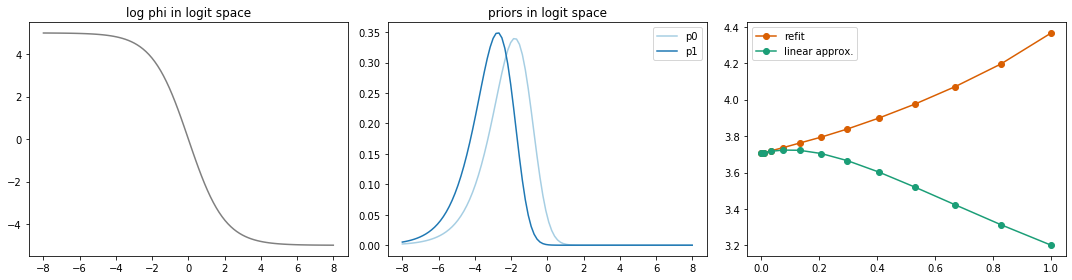

In [65]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 

# plot perturbation
prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = prior_params_dict['dp_prior_alpha'],
                                    log_phi = lambda x : f_obj.log_phi(x) * delta, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
        
# plot log-phi
logit_v_grid = np.linspace(-8, 8, 100)
ax[0].plot(logit_v_grid, 
         prior_perturbation.log_phi(logit_v_grid), 
         color = 'grey')
ax[0].set_title('log phi in logit space')

# plot priors
ax[1].plot(logit_v_grid, 
         np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
         color = '#a6cee3', label = 'p0')
ax[1].plot(logit_v_grid, 
         np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
         color = '#1f78b4', label = 'p1')

ax[1].set_title('priors in logit space')
ax[1].legend()

# plot number of clusters
plot_e_num_clusters(vb_refit_list, lr_list, epsilon_vec, ax[2])

fig.tight_layout()

In [66]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt, ax, color = 'red'): 
    ax.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = color)

    ax.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

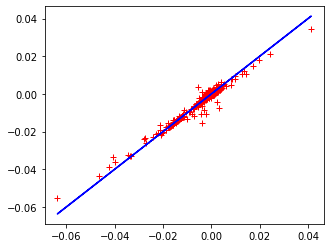

In [67]:
assert np.all(vb_refit_list[0] == lr_list[0])
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
print_diff_plot(lr_list[1], vb_refit_list[1], vb_refit_list[0], ax0, color = 'red')

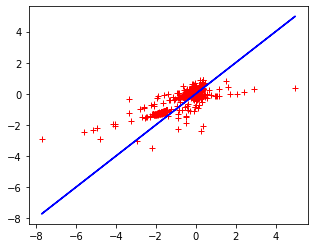

In [68]:
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
print_diff_plot(lr_list[-1], vb_refit_list[-1], vb_refit_list[0], ax0, color = 'red')

# Effect on logitnormal mean parameter. 
LR should be linear here

In [69]:
def get_logitnormal_mean_param(vb_free_params, vb_params_paragami): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    return vb_params_dict['ind_admix_params']['stick_means']

In [70]:
refit_array = []
lr_array = []

for i in range(len(epsilon_vec)): 
    refit_array.append(get_logitnormal_mean_param(vb_refit_list[i], vb_params_paragami))
    lr_array.append(get_logitnormal_mean_param(lr_list[i], vb_params_paragami))

lr_array = np.array(lr_array)
refit_array = np.array(refit_array)

<ipython-input-71-7114fd0d5433>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, k_sub, figsize = (24, 4))


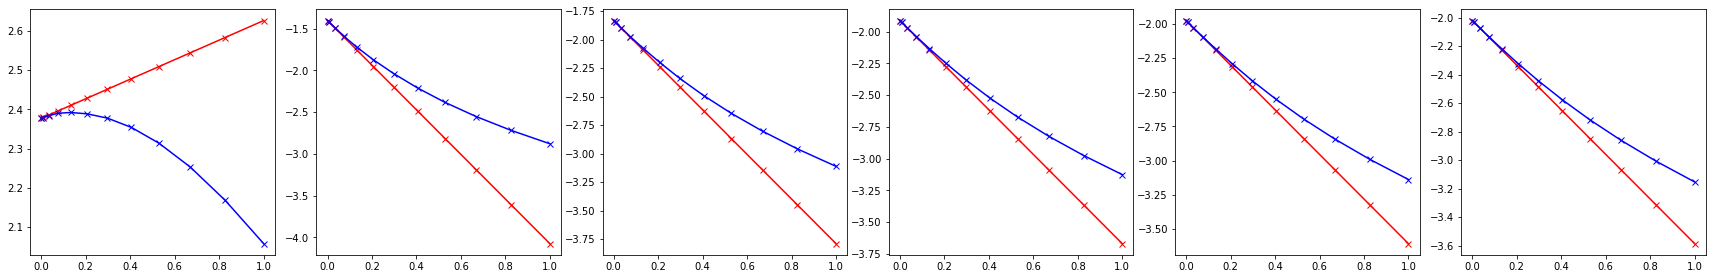

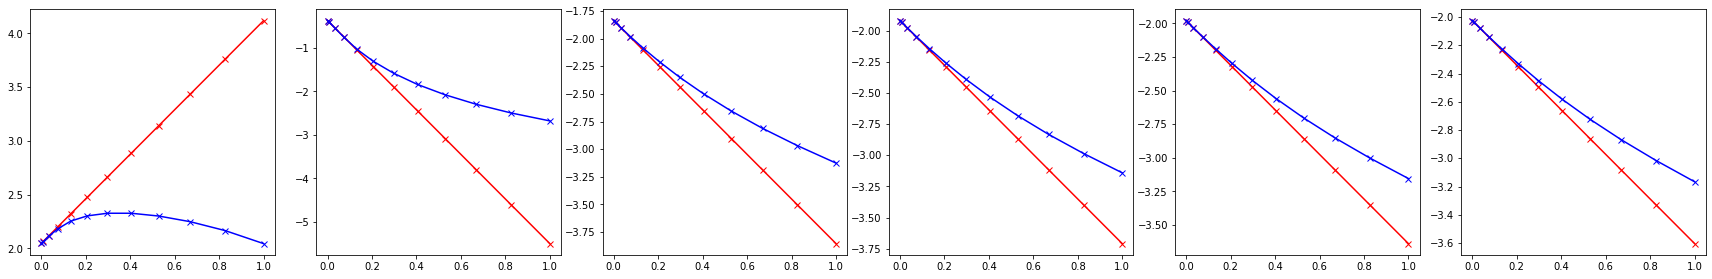

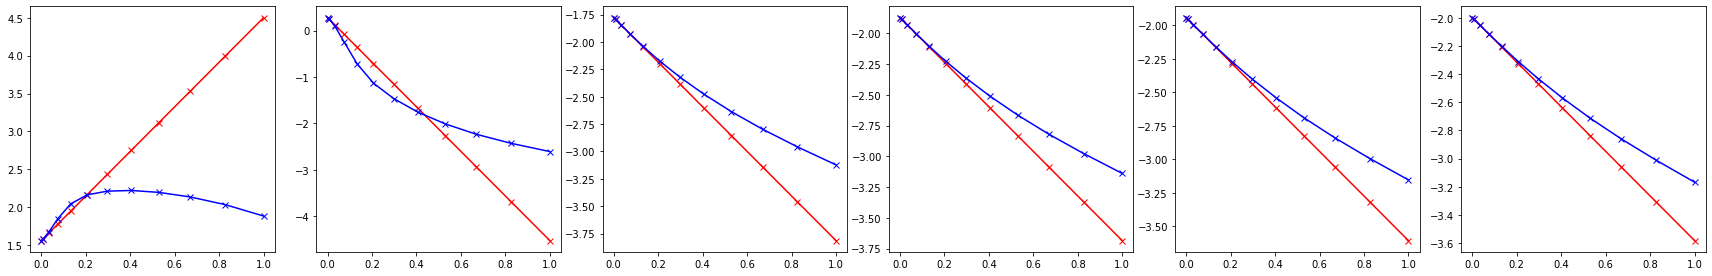

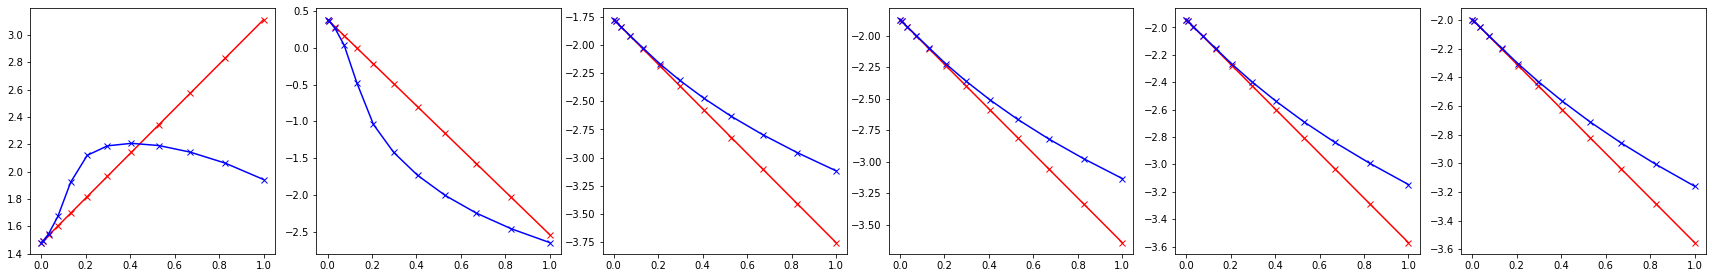

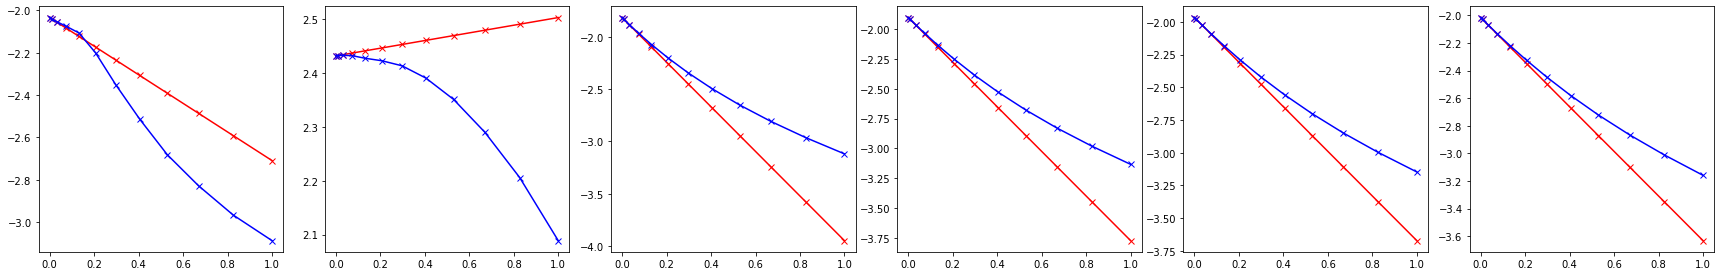

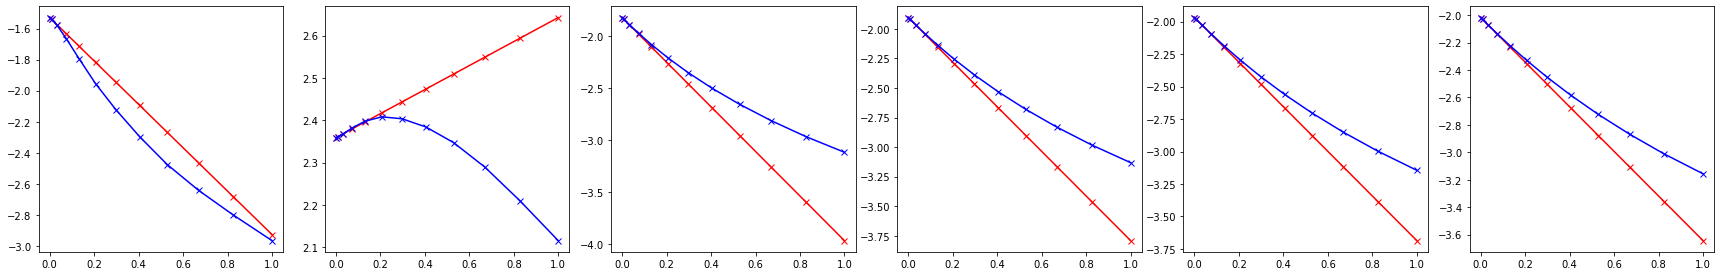

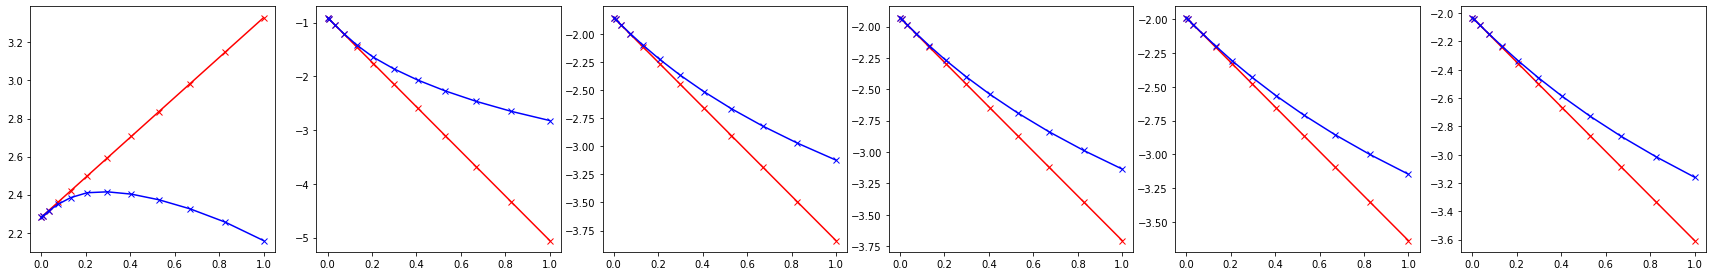

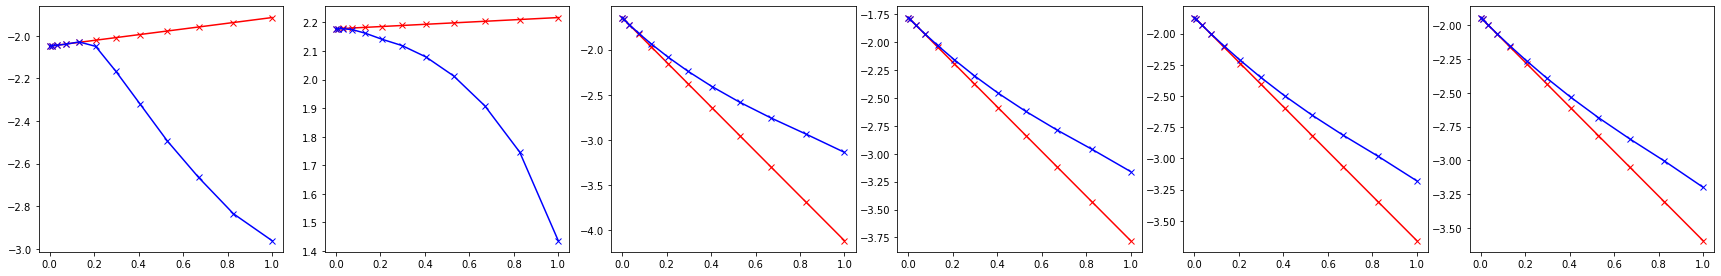

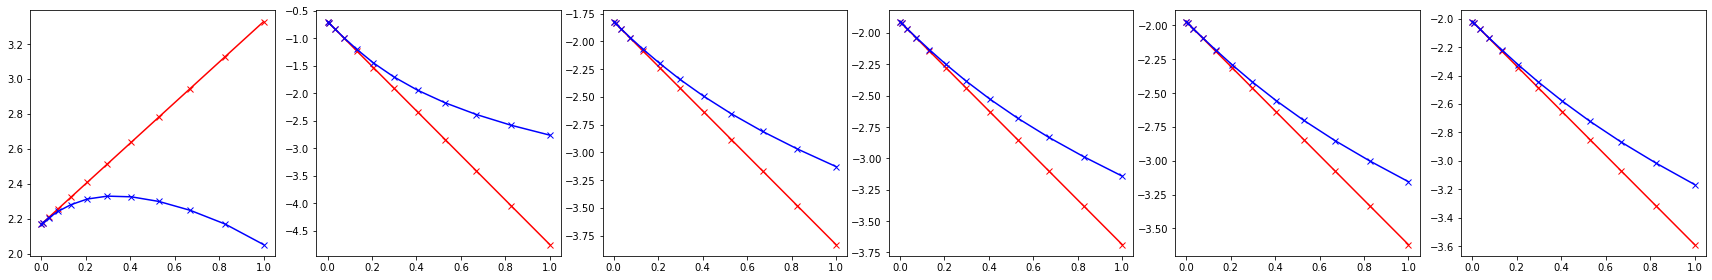

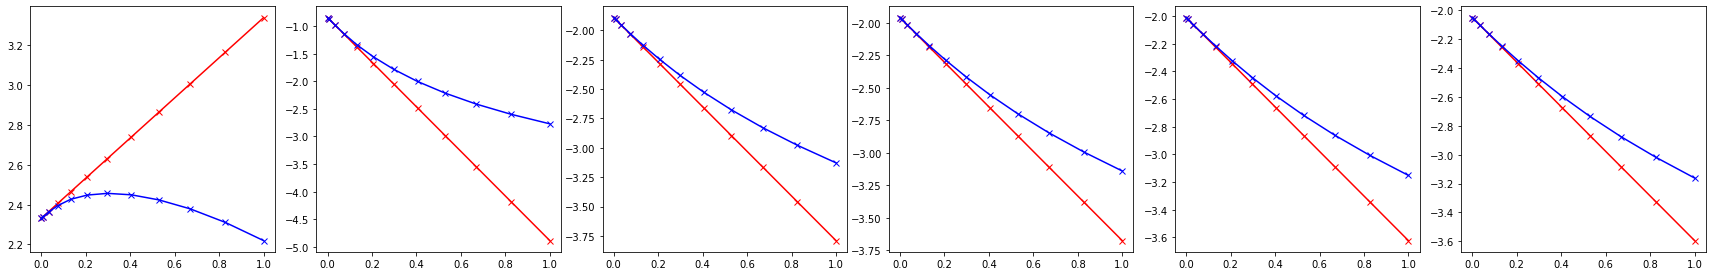

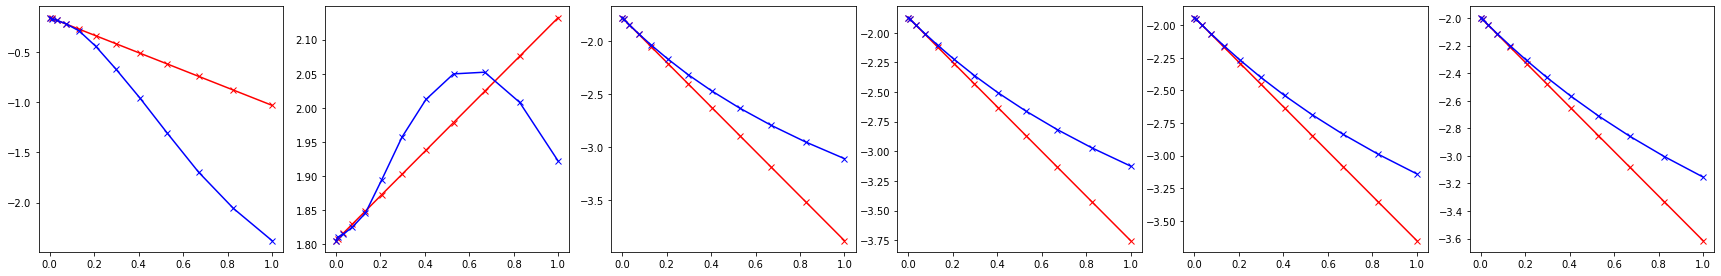

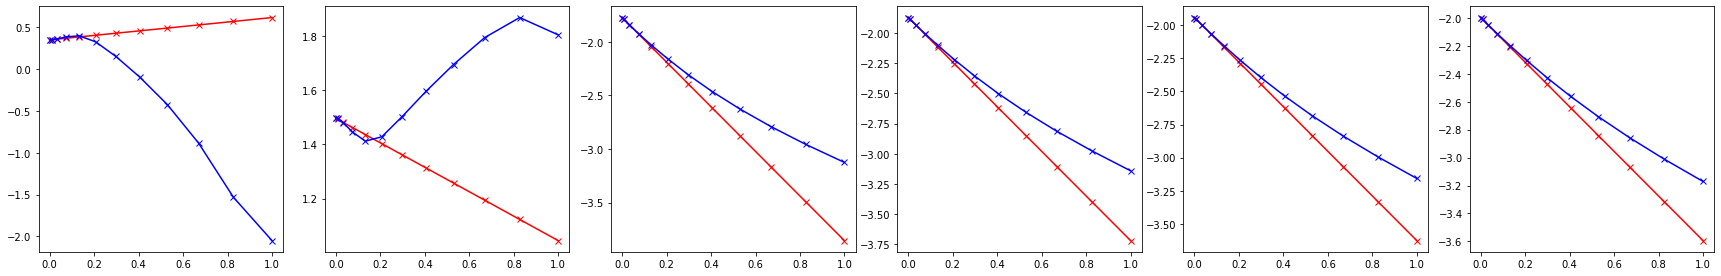

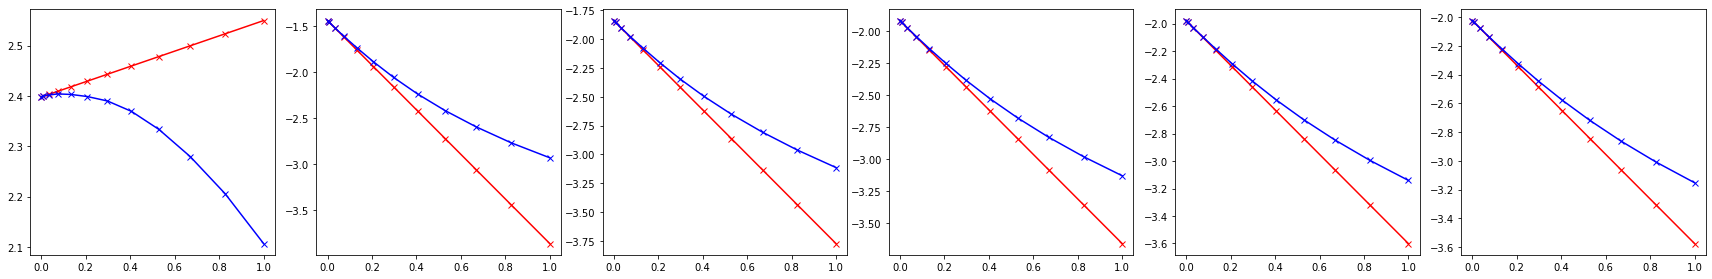

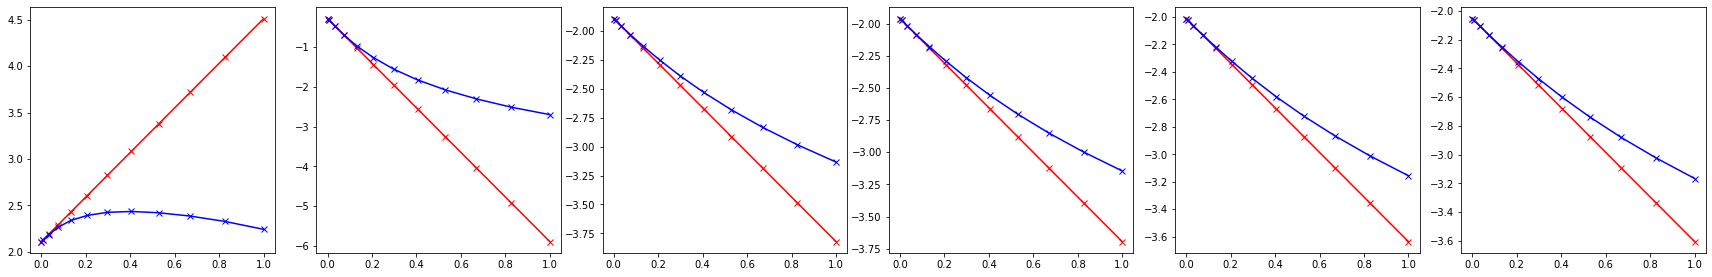

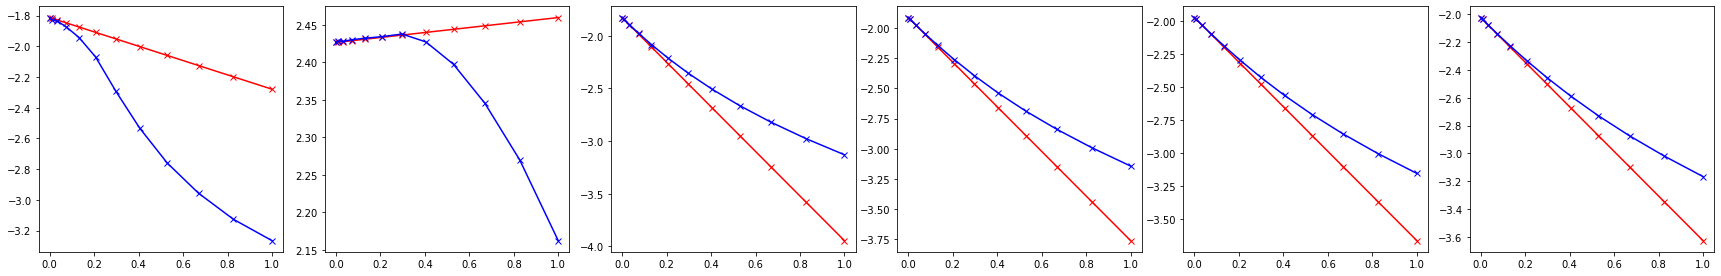

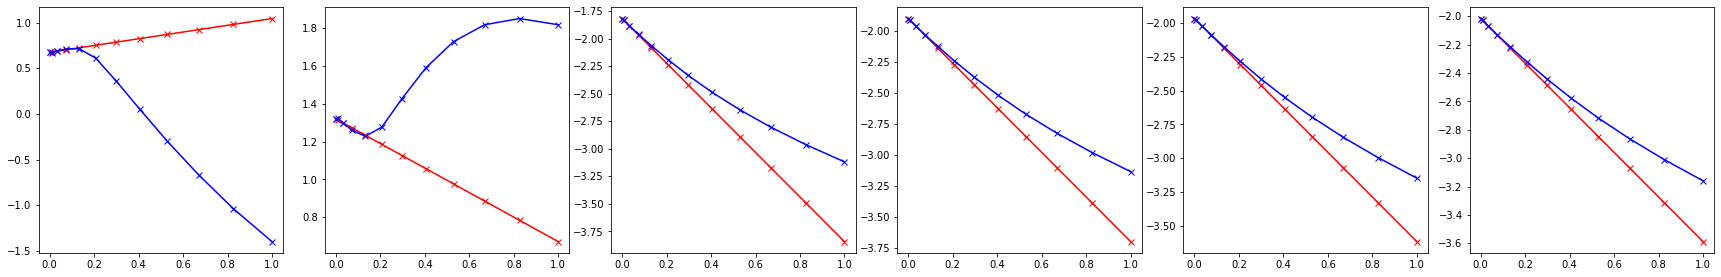

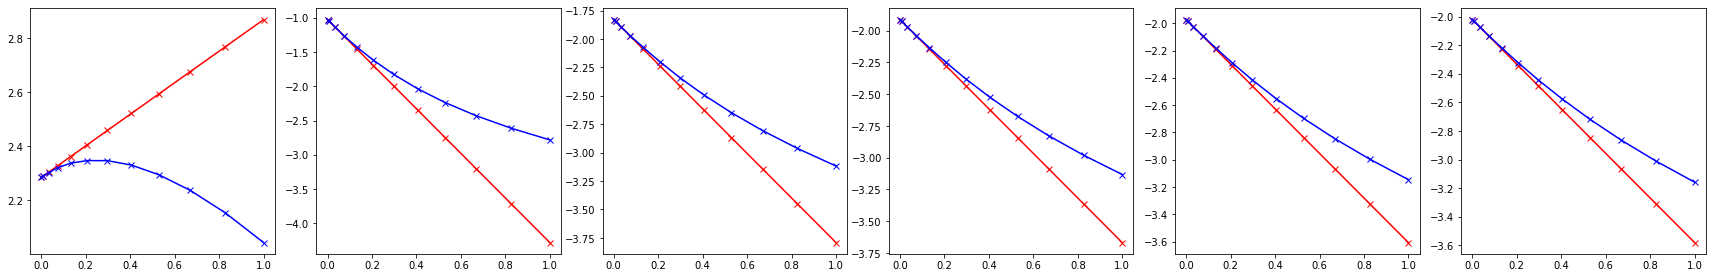

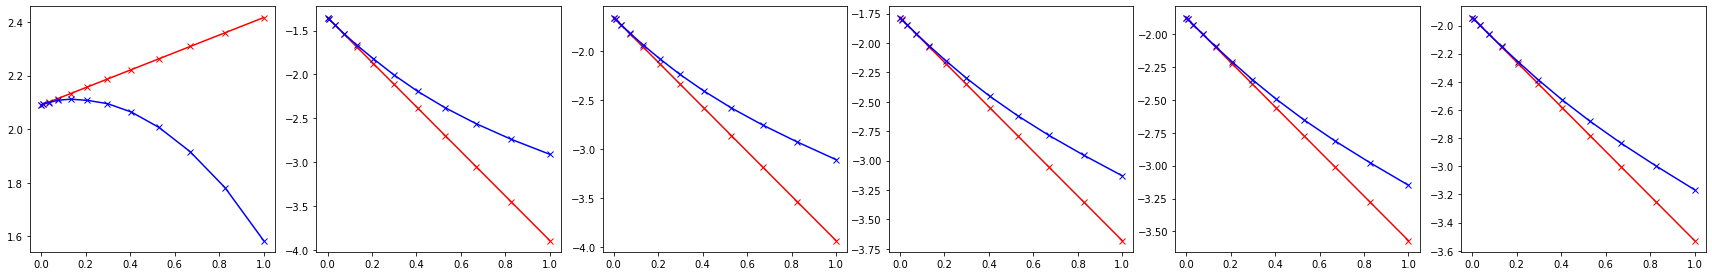

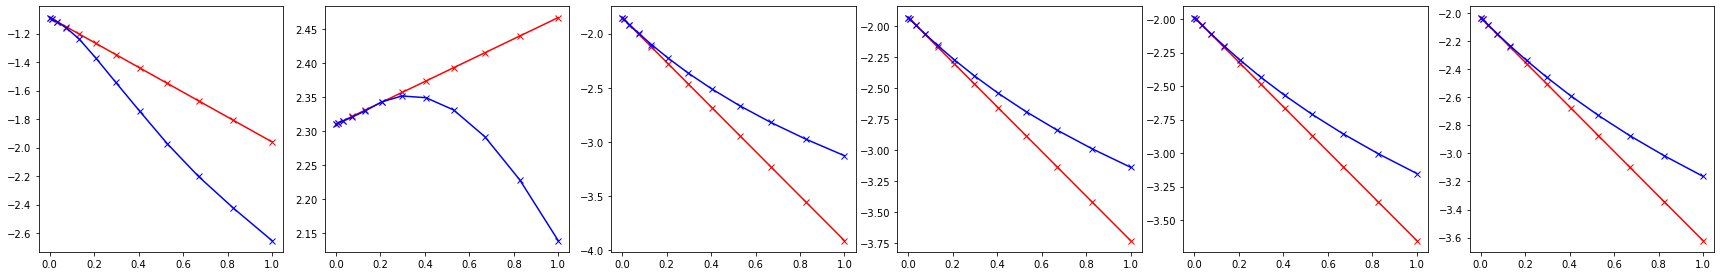

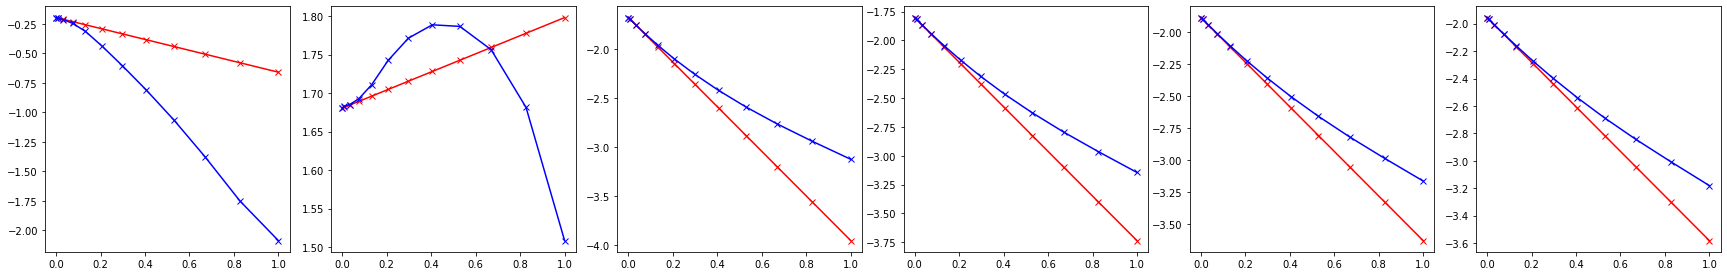

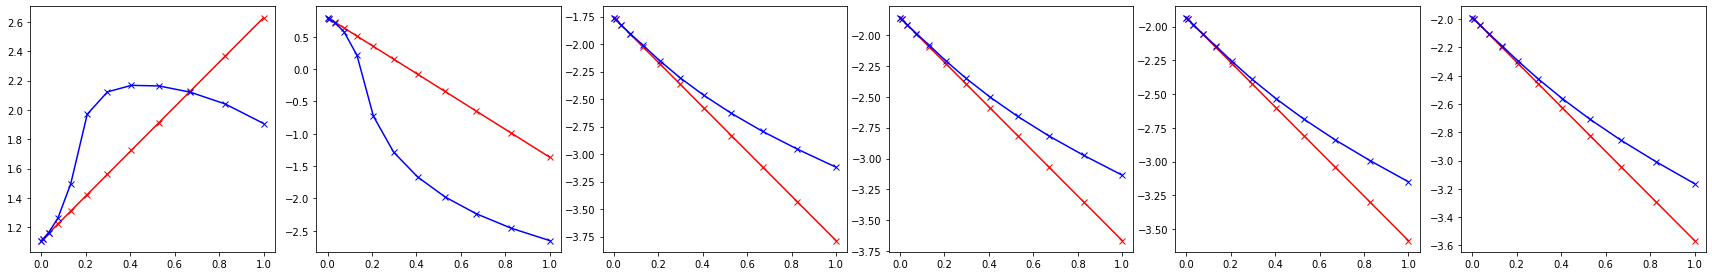

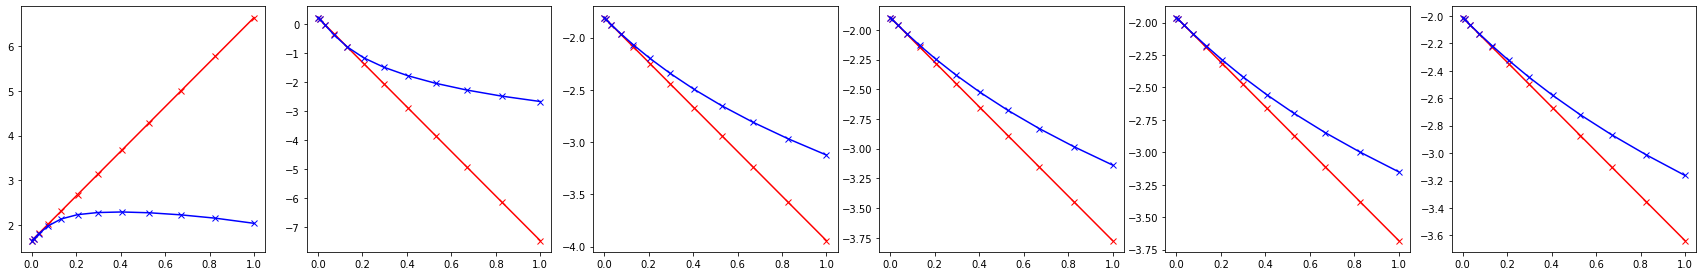

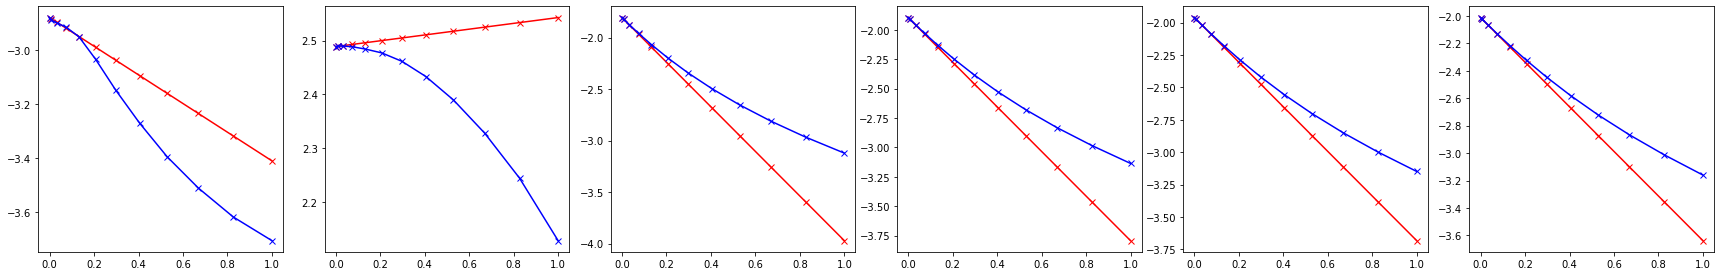

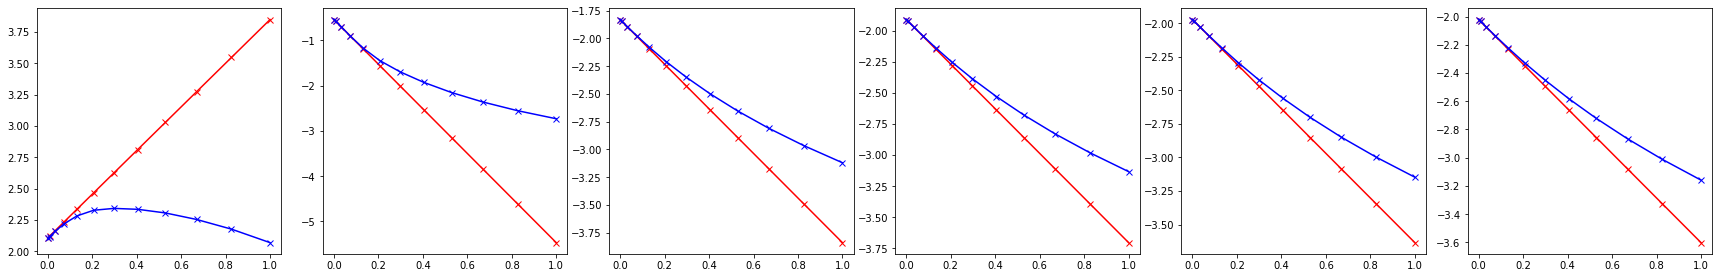

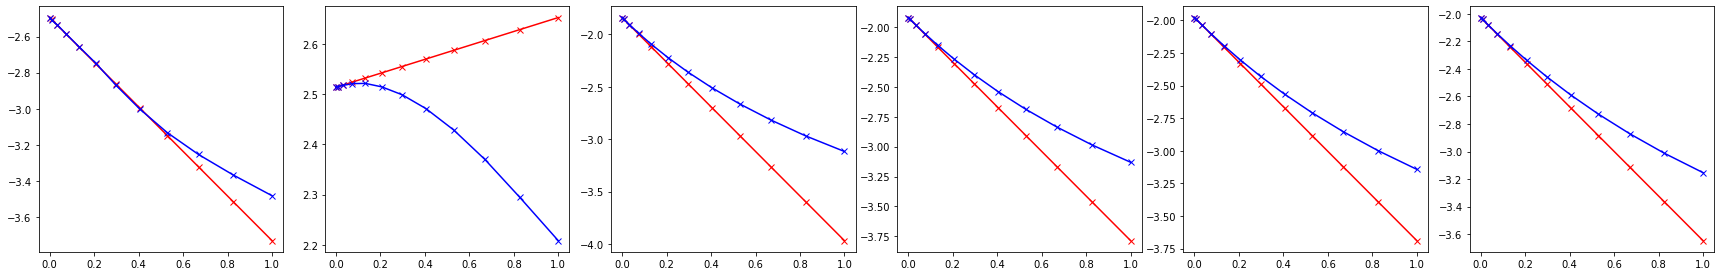

In [71]:
k_sub = 6

for n in range(g_obs.shape[0]): 

    fig, ax = plt.subplots(1, k_sub, figsize = (24, 4))
    fig.tight_layout()

    for k in range(k_sub): 
        ax[k].plot(epsilon_vec, lr_array[:, n, k], '-x', color = 'red')
        ax[k].plot(epsilon_vec, refit_array[:, n, k], '-x', color = 'blue')

# On expectation of sticks

In [72]:
def get_e_sticks(vb_free_params, vb_params_paragami): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    lognorm_means = vb_params_dict['ind_admix_params']['stick_means']
    lognorm_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return ef.get_e_logitnormal(lognorm_means, lognorm_infos, gh_loc, gh_weights)

In [73]:
refit_array = []
lr_array = []

for i in range(len(epsilon_vec)): 
    refit_array.append(get_e_sticks(vb_refit_list[i], vb_params_paragami))
    lr_array.append(get_e_sticks(lr_list[i], vb_params_paragami))

lr_array = np.array(lr_array)
refit_array = np.array(refit_array)

<ipython-input-74-7114fd0d5433>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, k_sub, figsize = (24, 4))


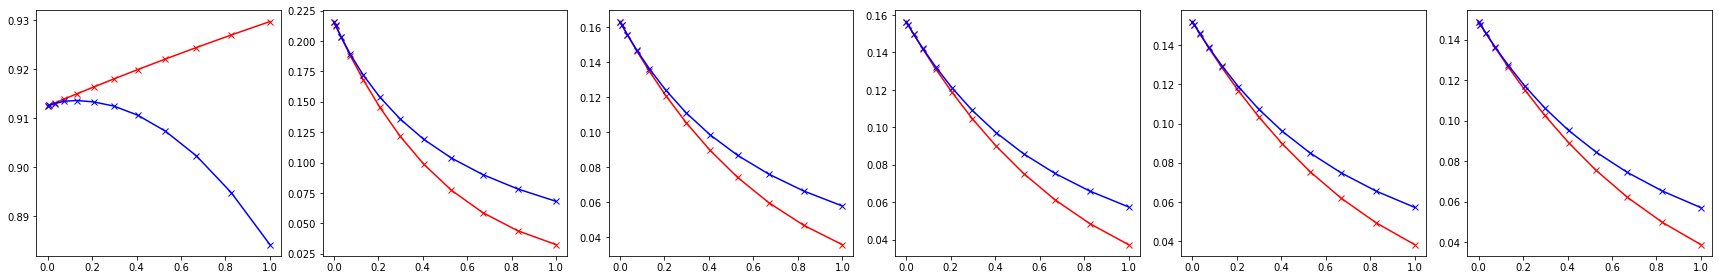

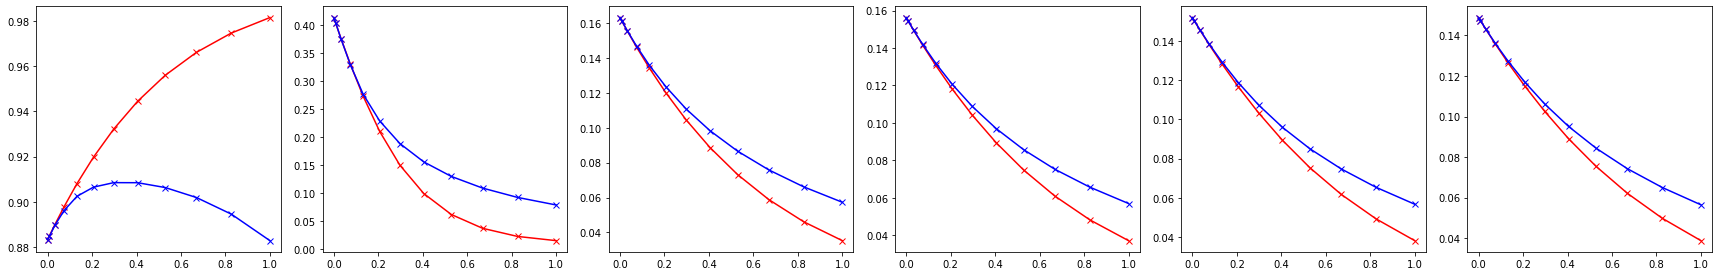

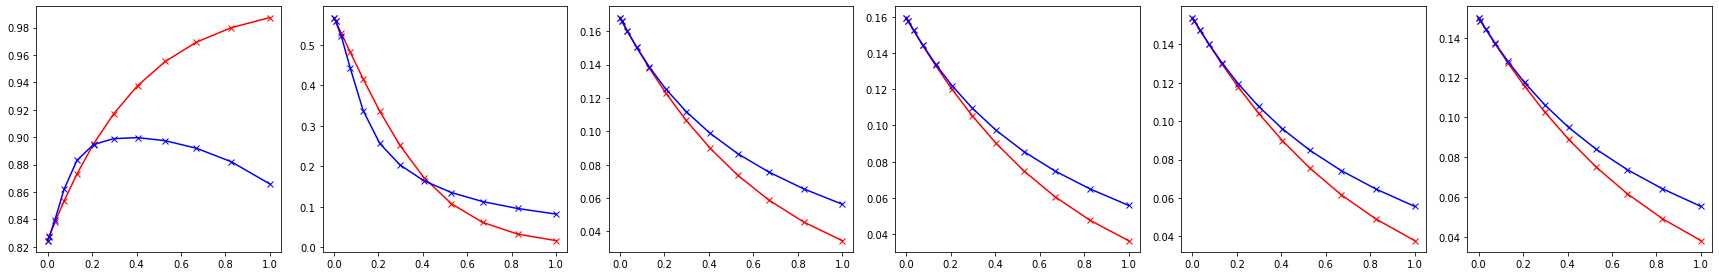

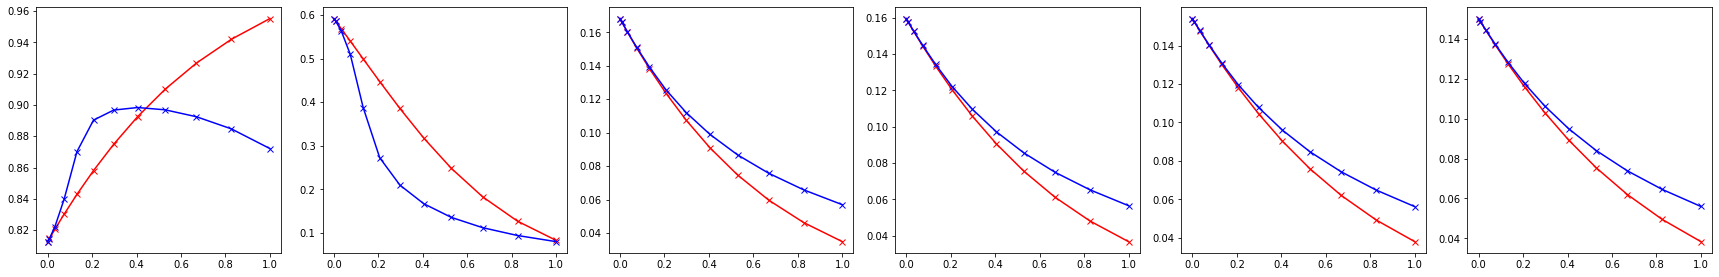

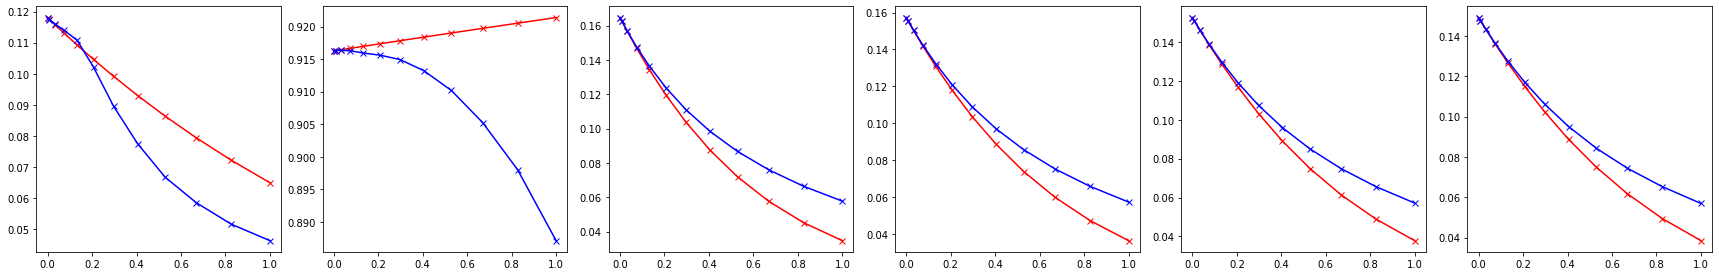

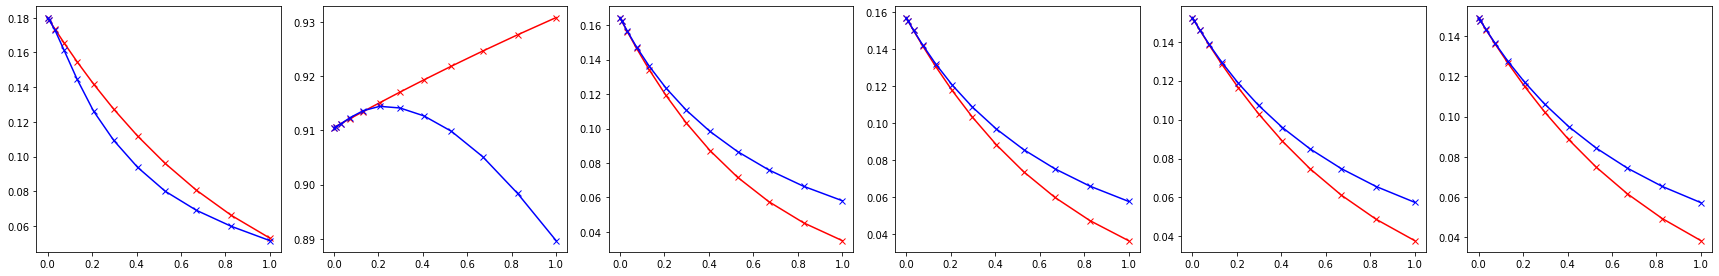

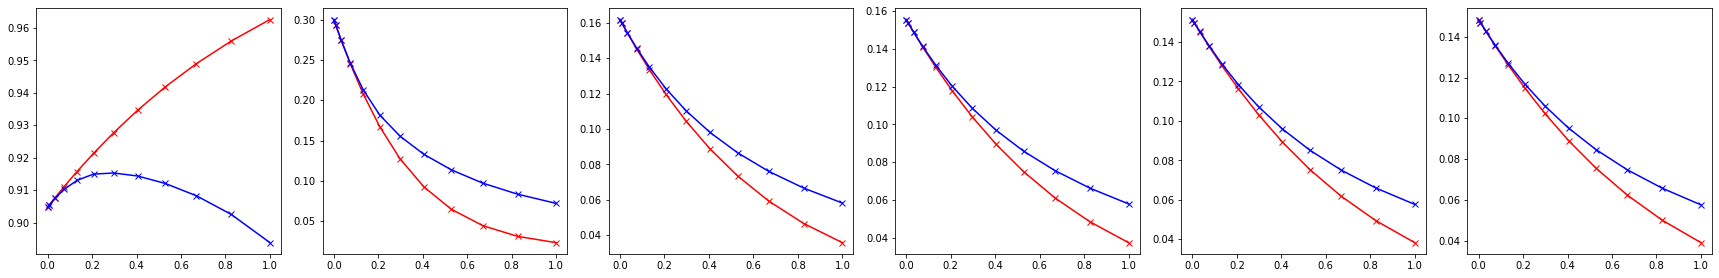

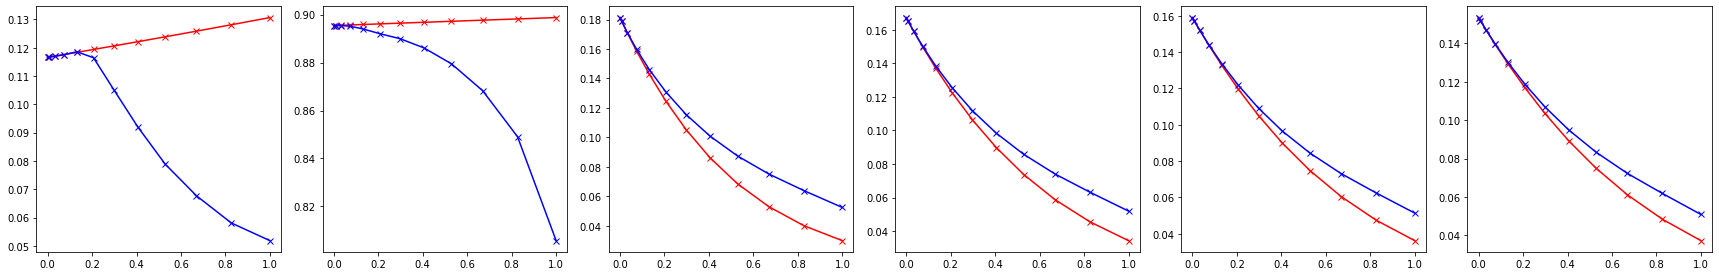

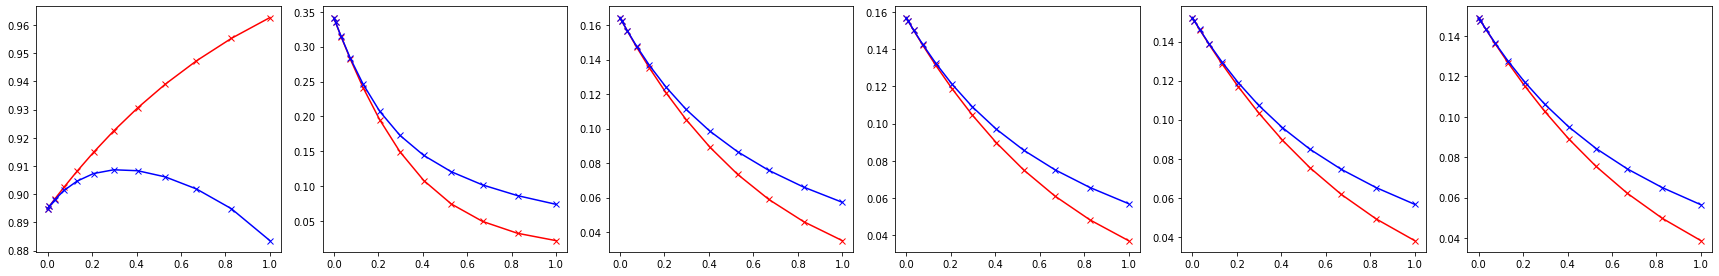

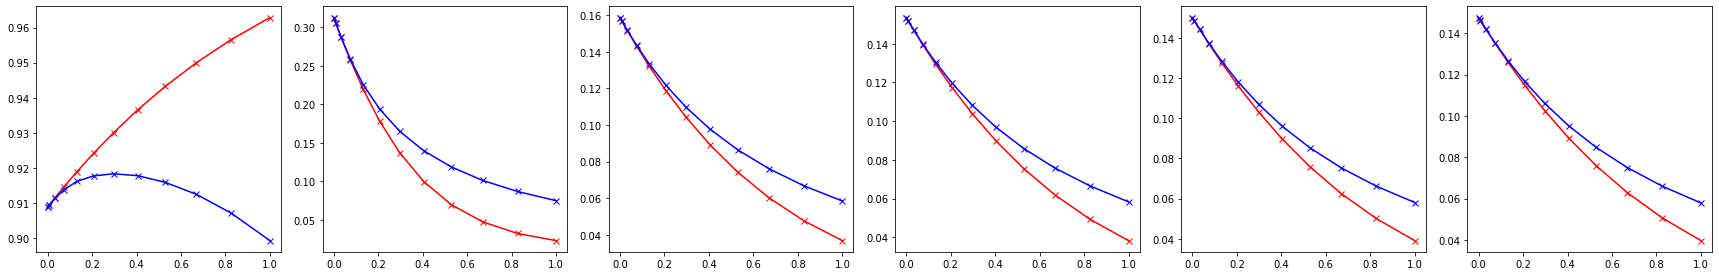

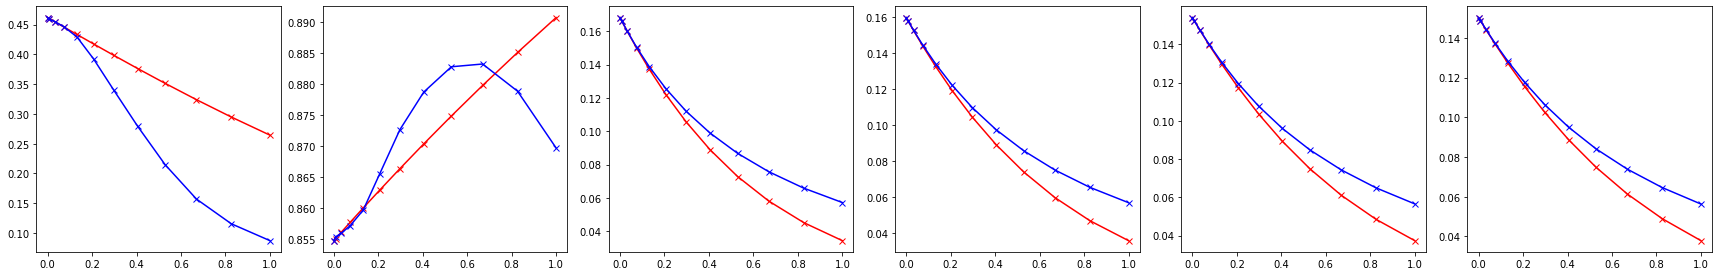

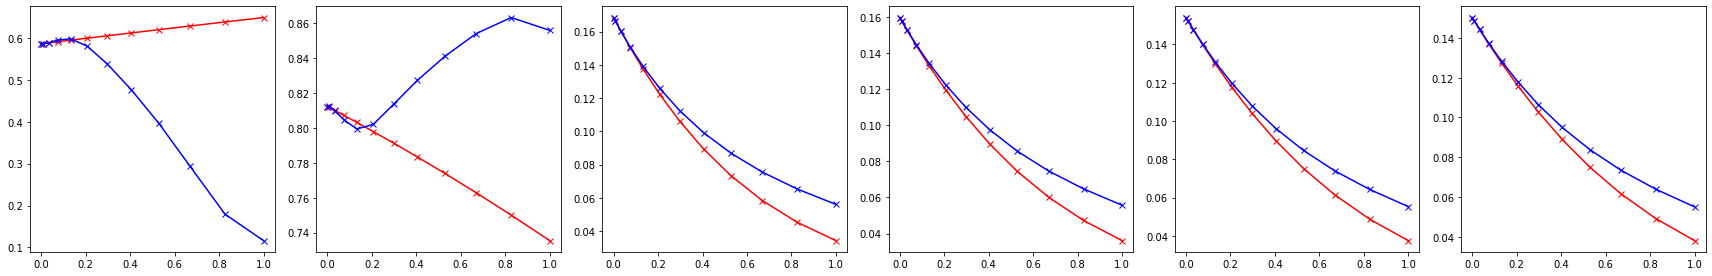

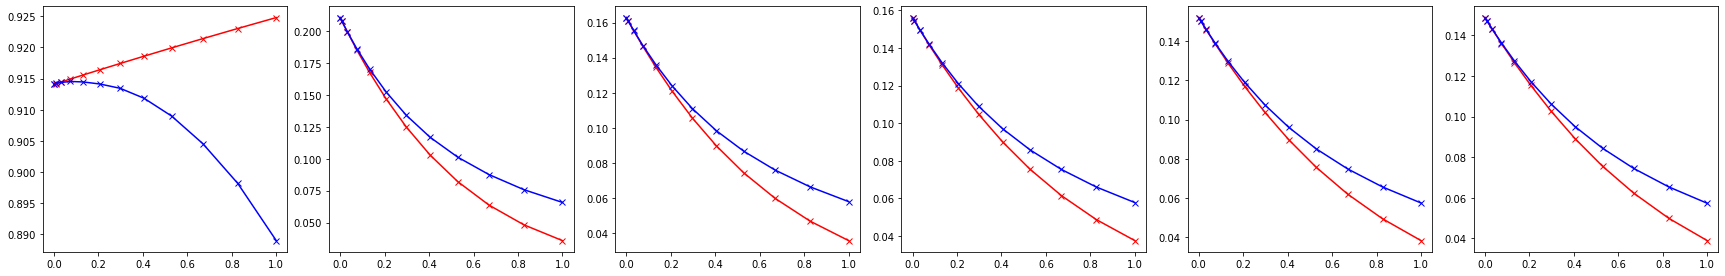

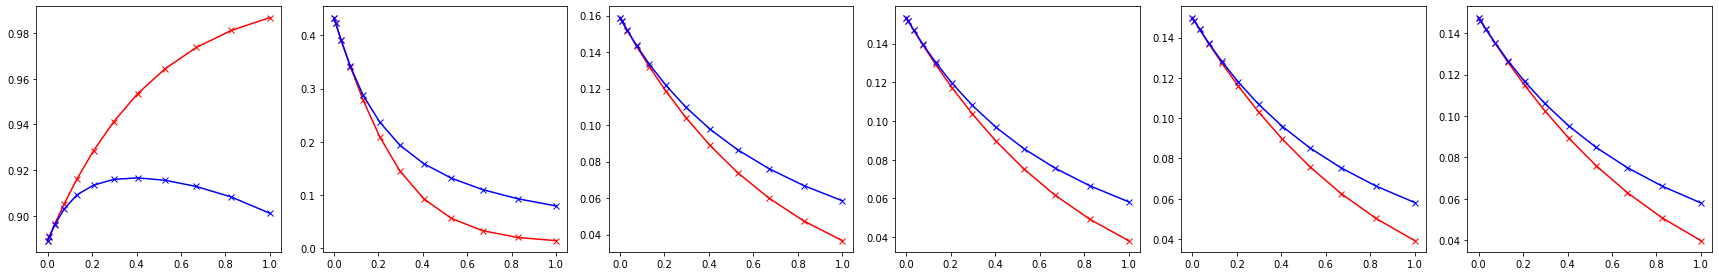

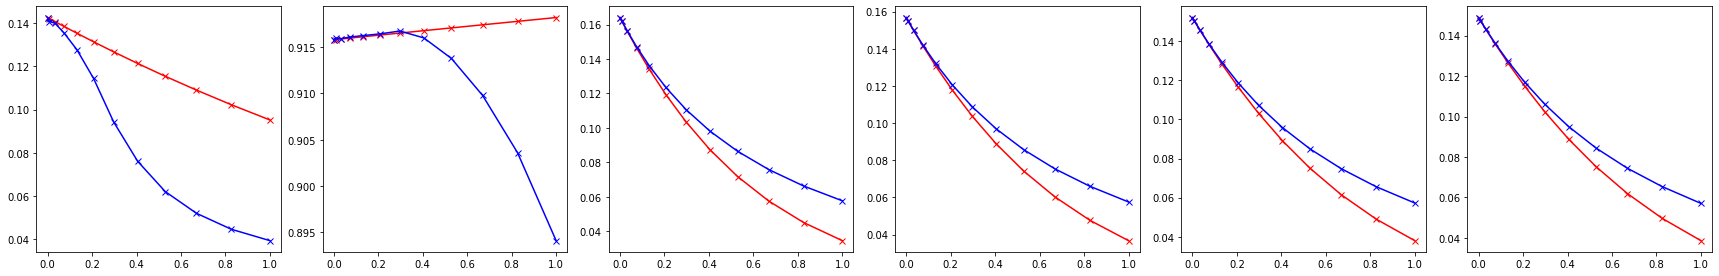

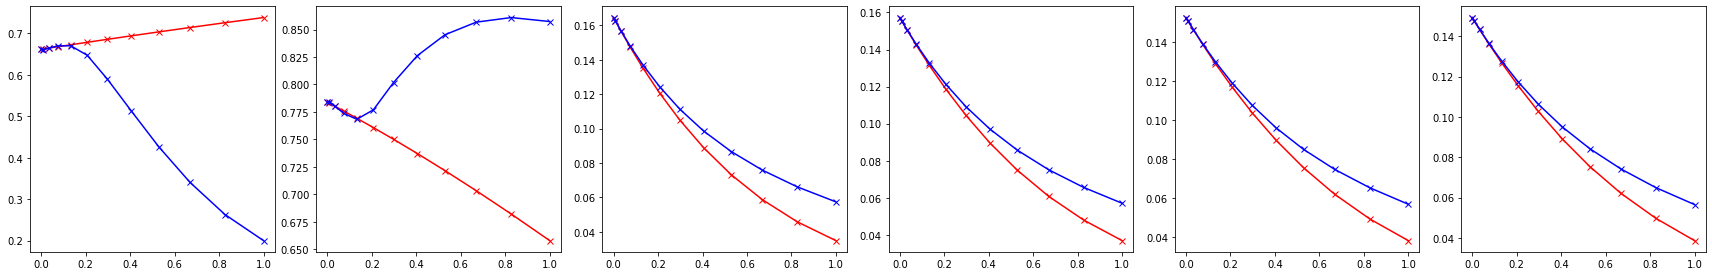

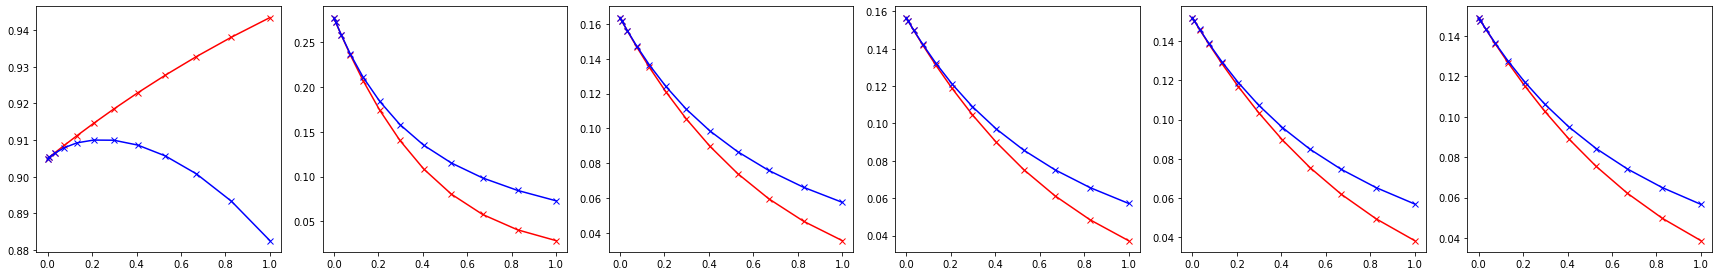

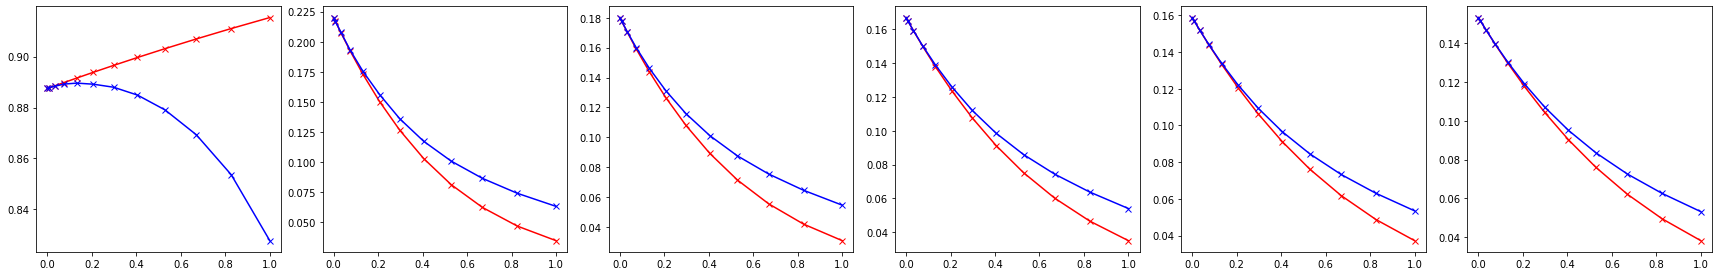

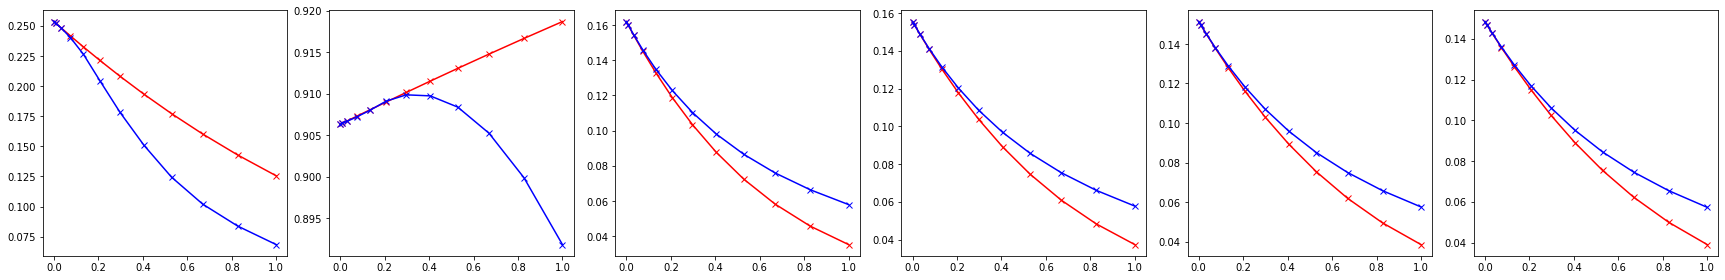

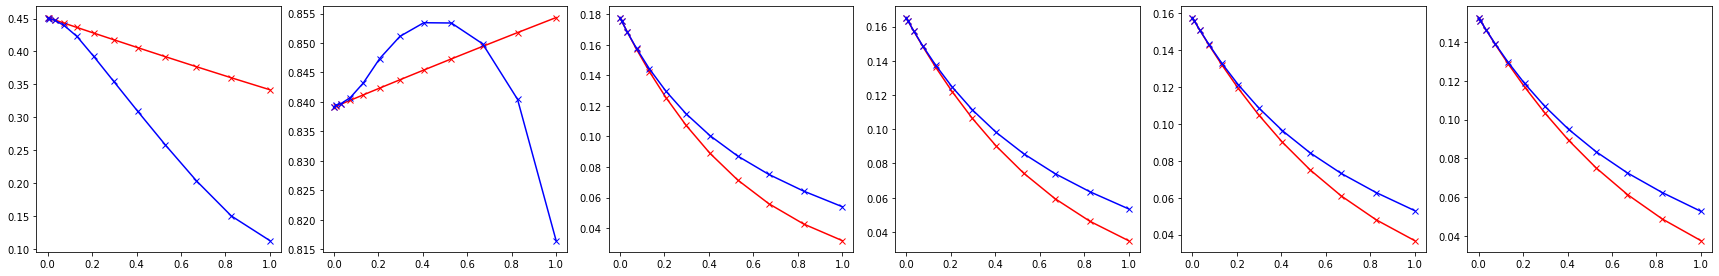

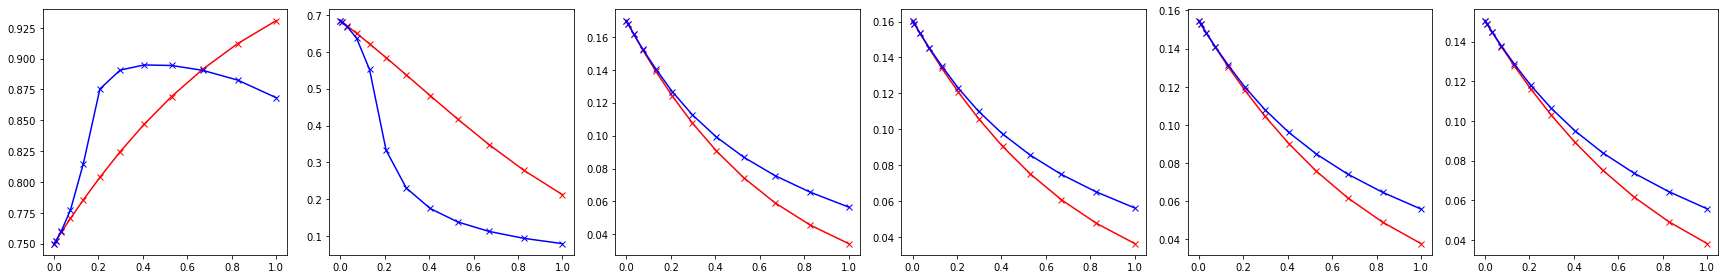

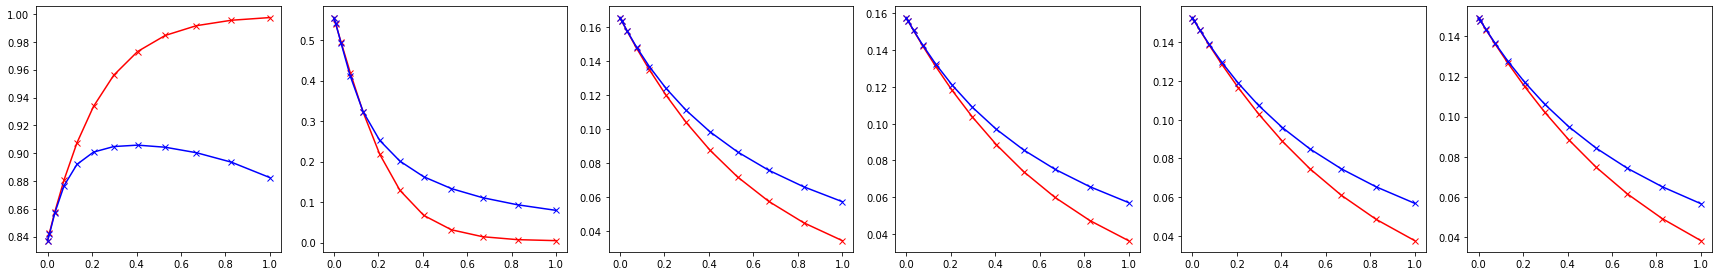

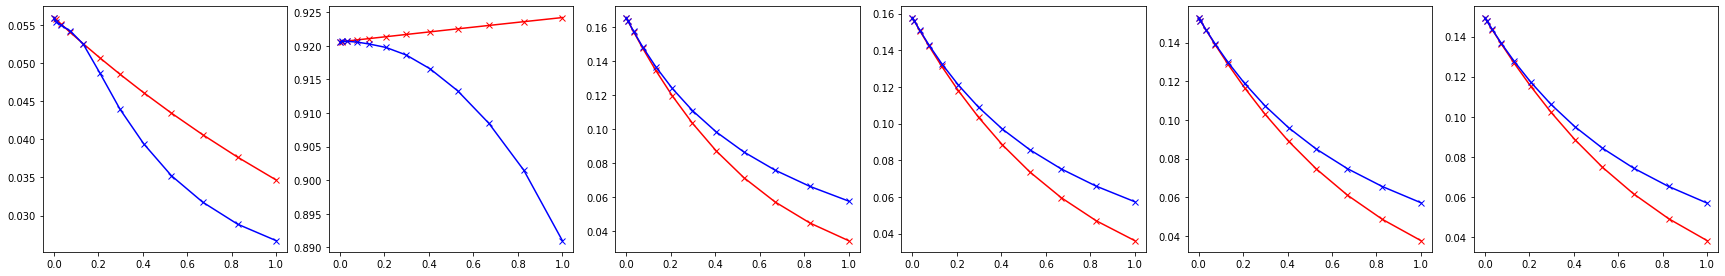

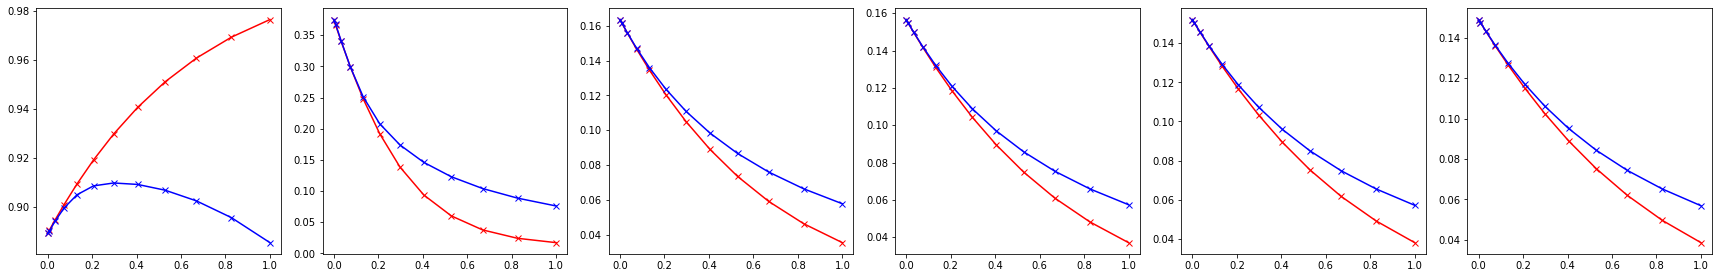

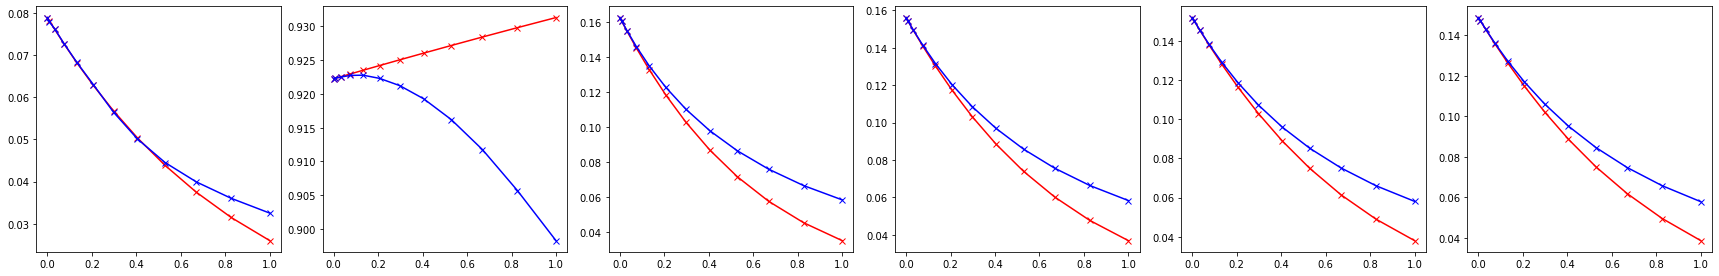

In [74]:
k_sub = 6

for n in range(g_obs.shape[0]): 

    fig, ax = plt.subplots(1, k_sub, figsize = (24, 4))
    fig.tight_layout()

    for k in range(k_sub): 
        ax[k].plot(epsilon_vec, lr_array[:, n, k], '-x', color = 'red')
        ax[k].plot(epsilon_vec, refit_array[:, n, k], '-x', color = 'blue')

In [75]:
# On mixture proportions

In [76]:
refit_array = []
lr_array = []

for i in range(len(epsilon_vec)): 
    refit_array.append(get_e_ind_admix(vb_refit_list[i], vb_params_paragami))
    lr_array.append(get_e_ind_admix(lr_list[i], vb_params_paragami))

lr_array = np.array(lr_array)
refit_array = np.array(refit_array)

<ipython-input-77-7114fd0d5433>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, k_sub, figsize = (24, 4))


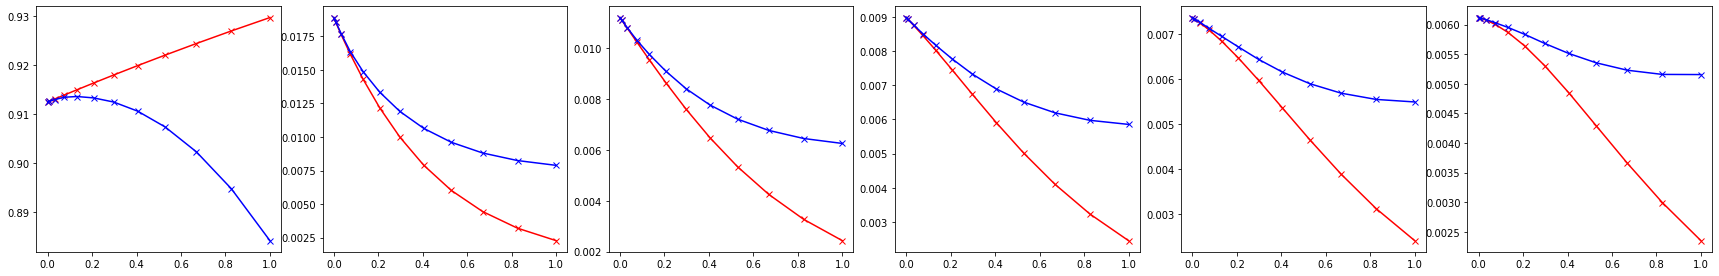

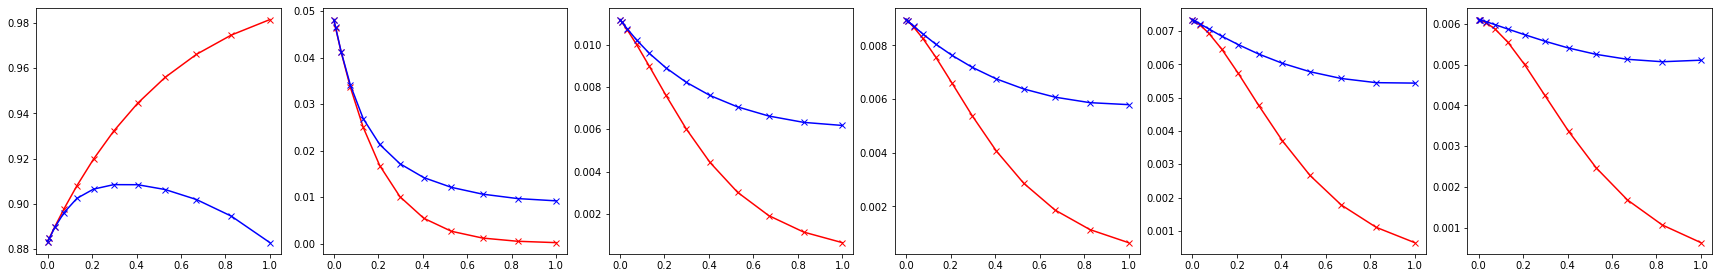

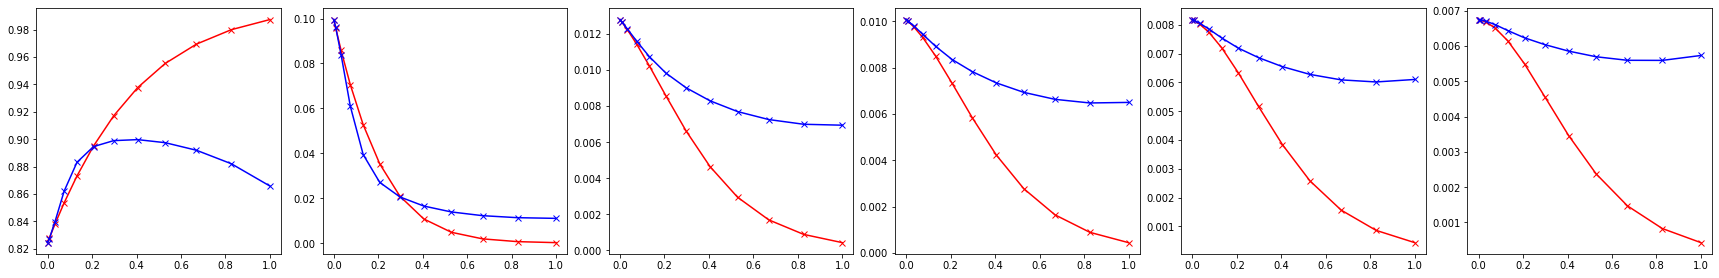

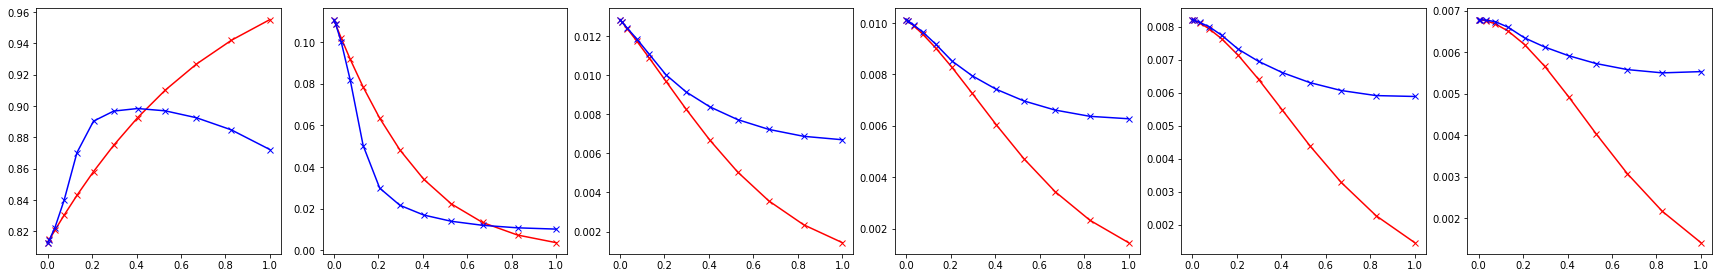

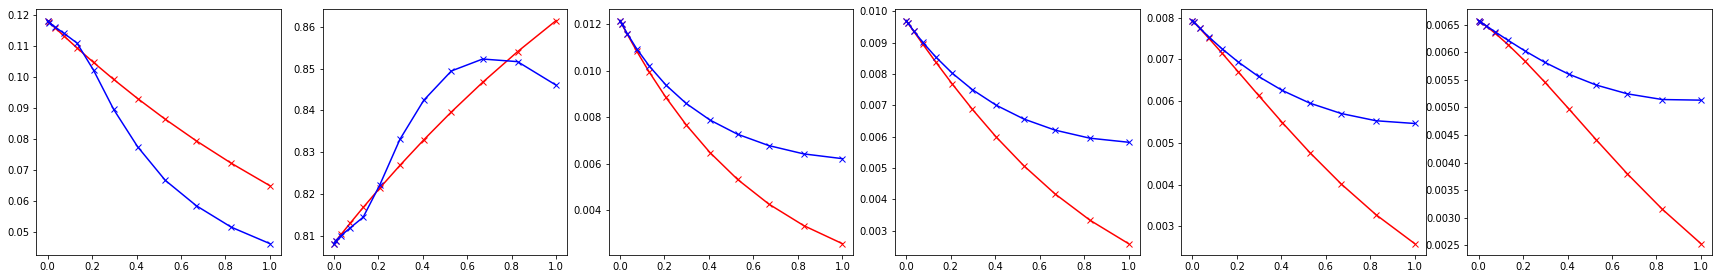

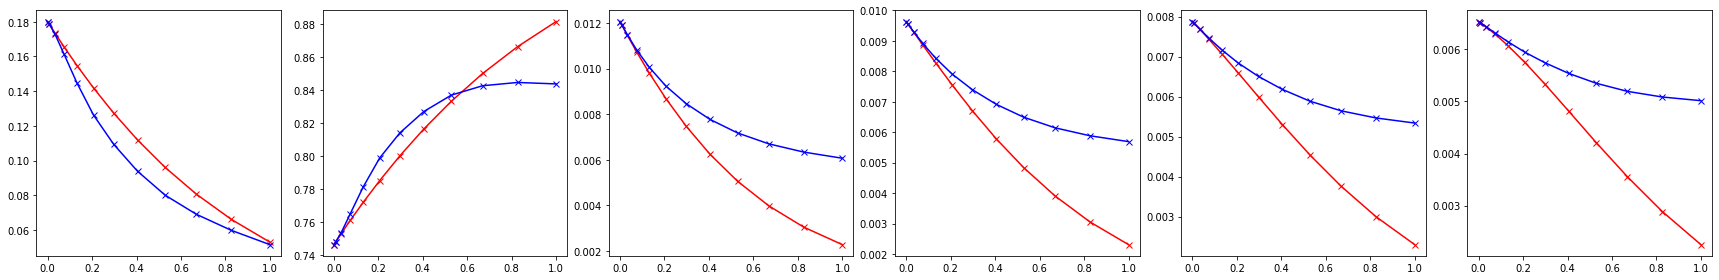

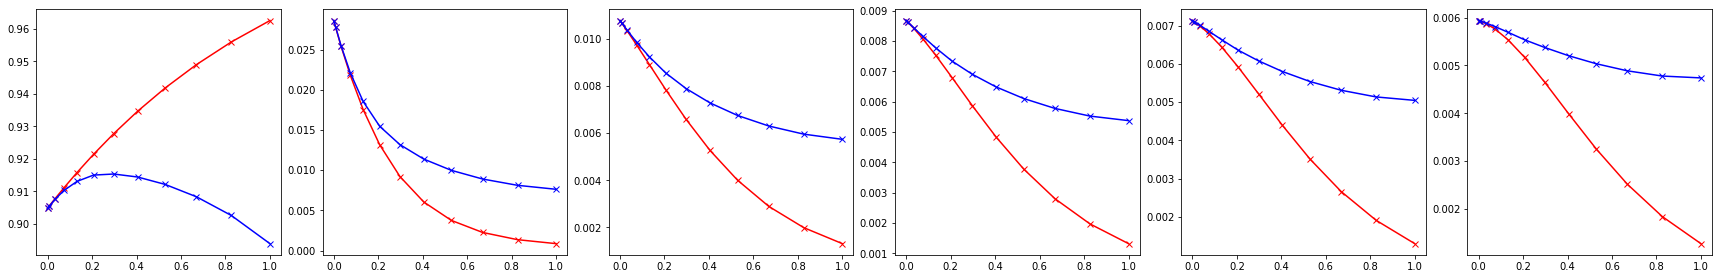

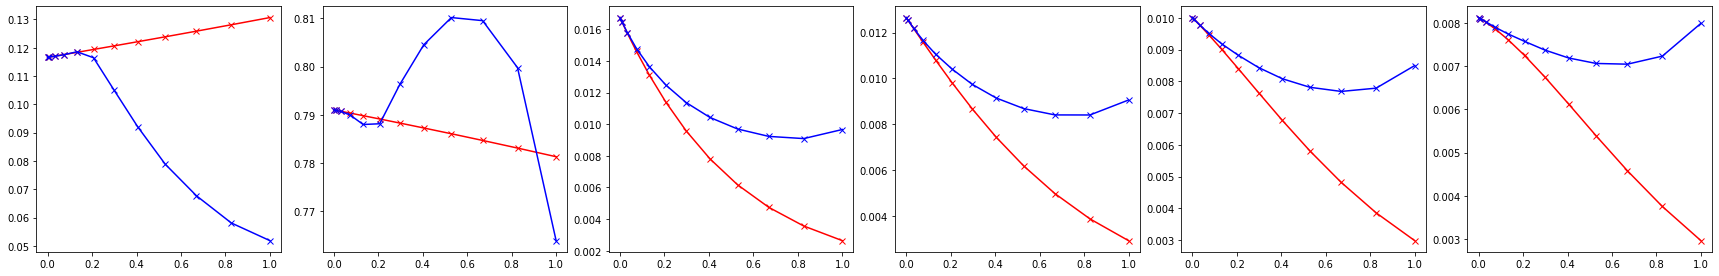

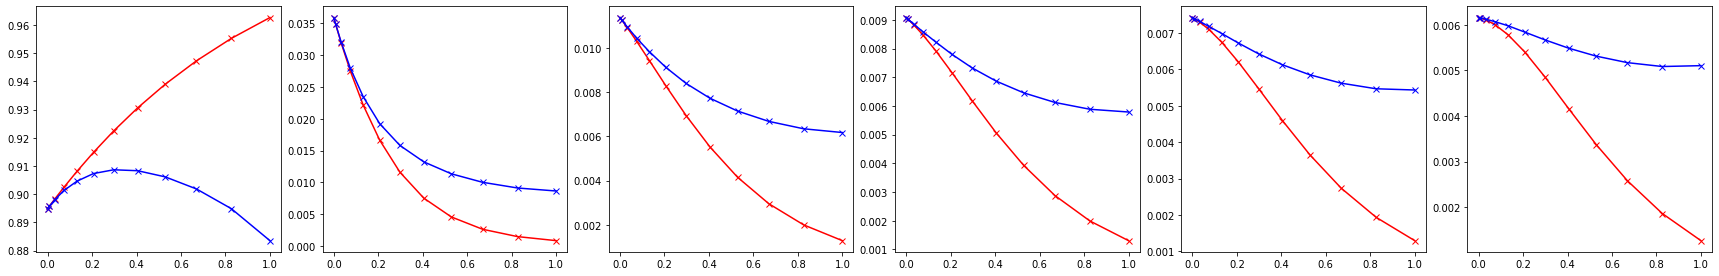

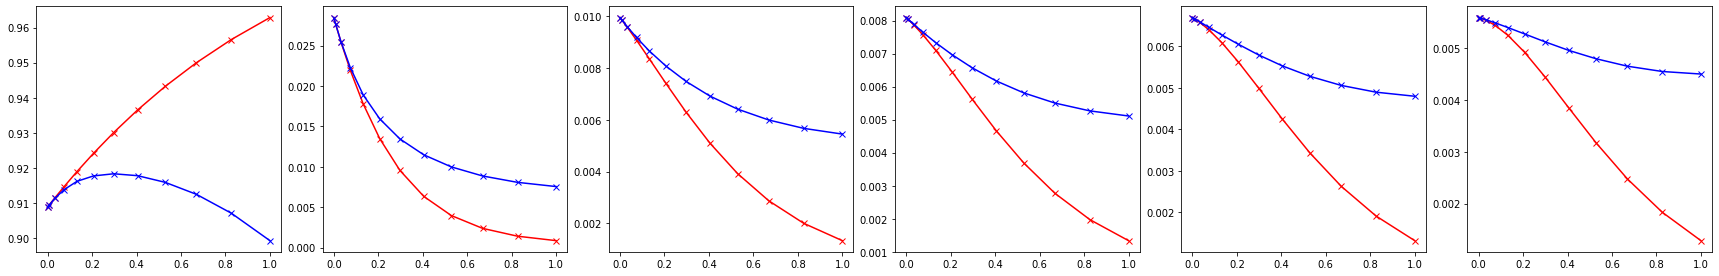

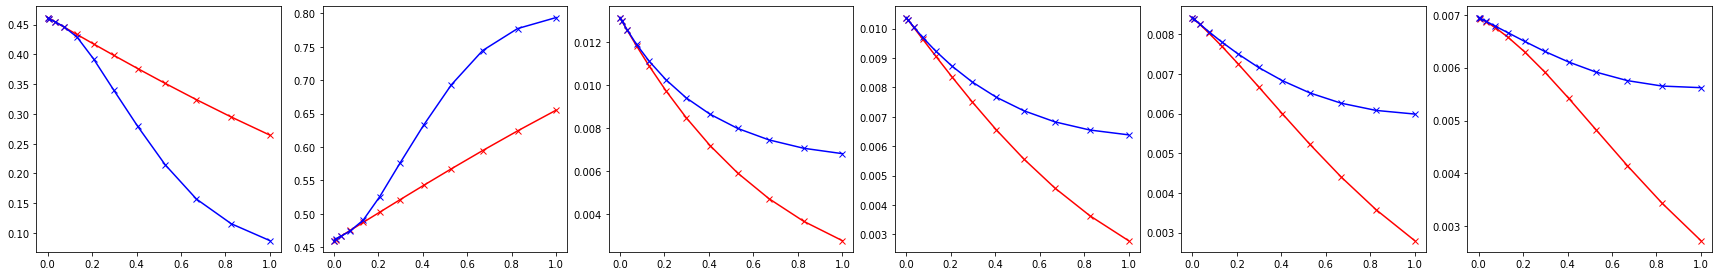

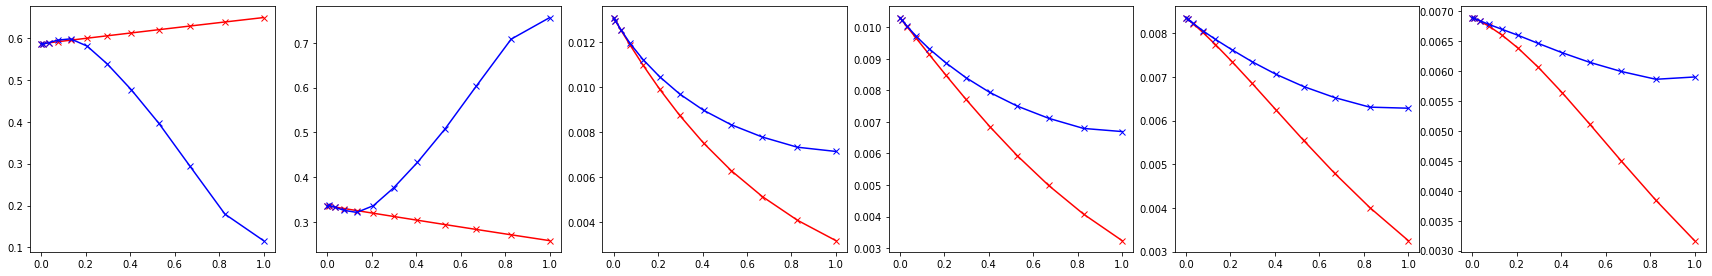

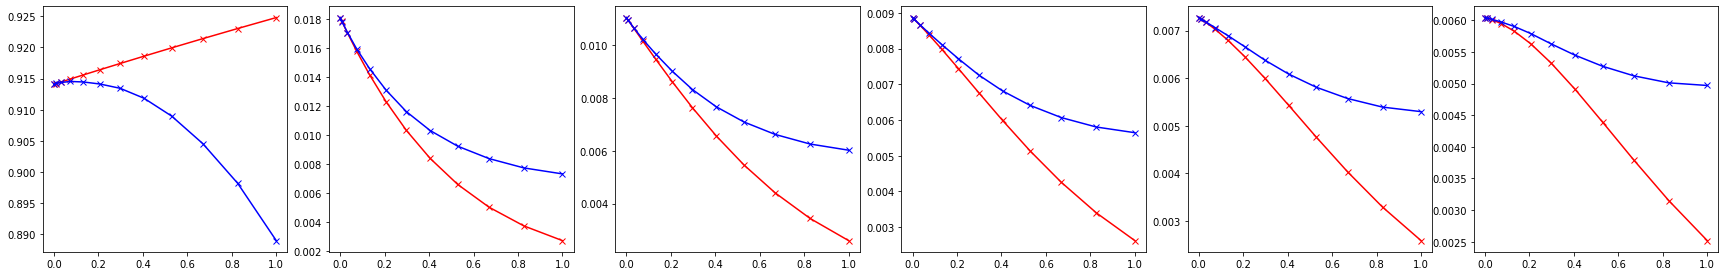

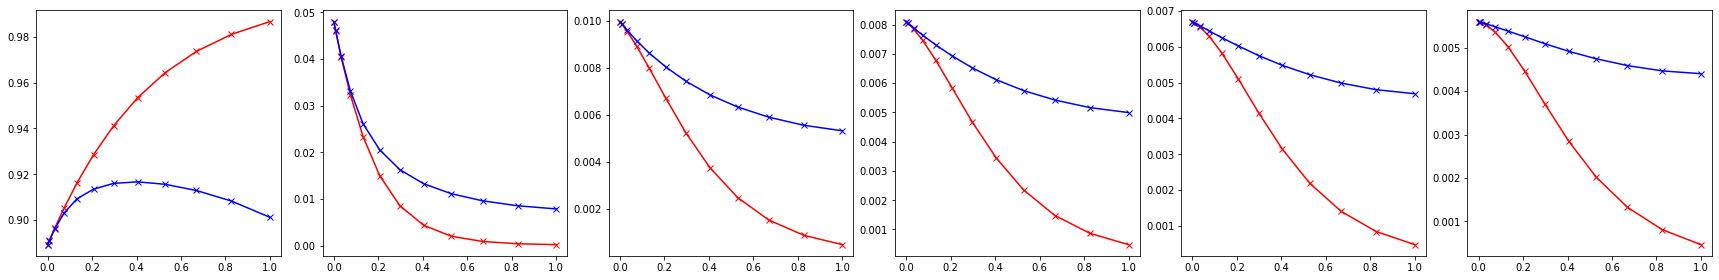

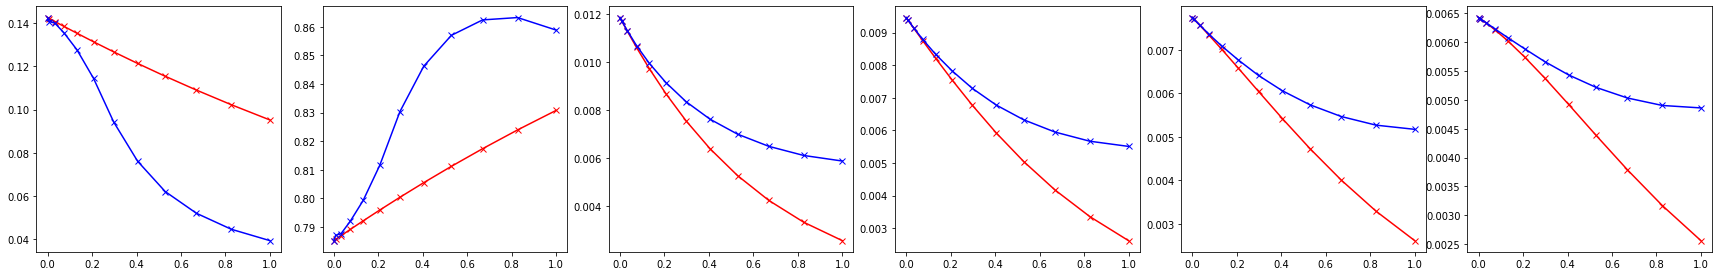

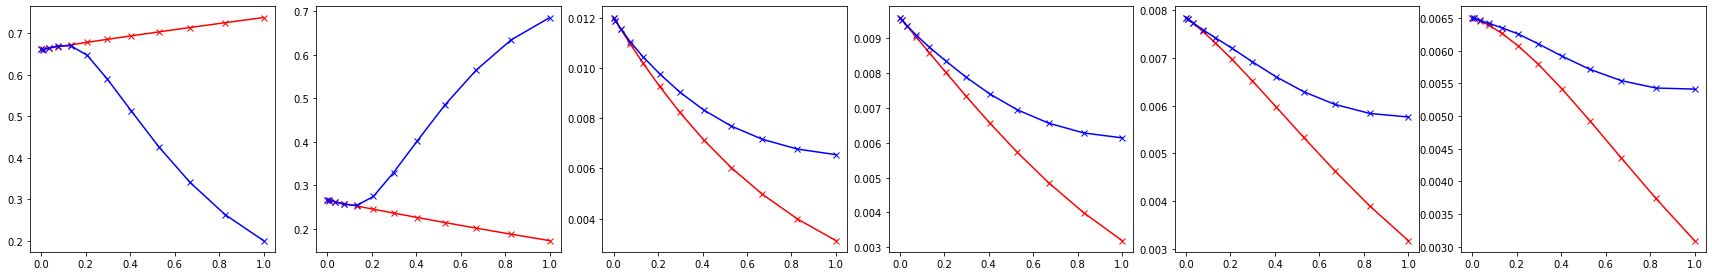

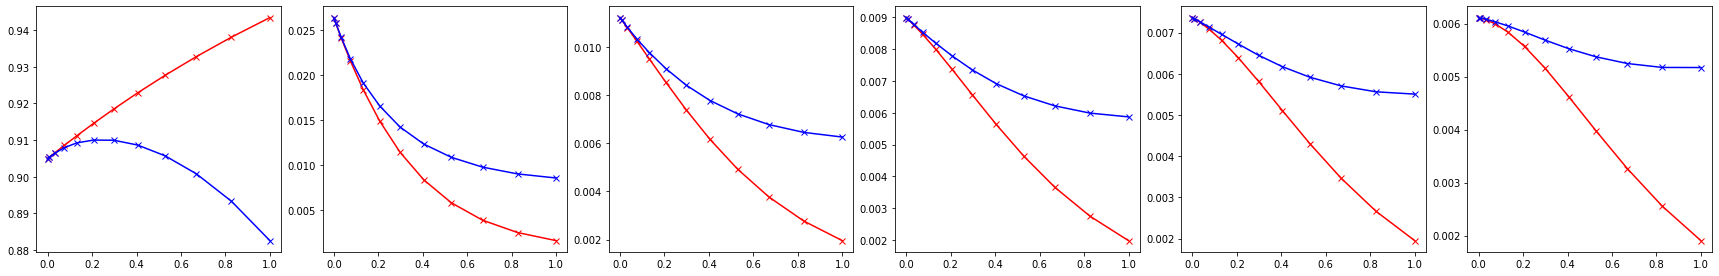

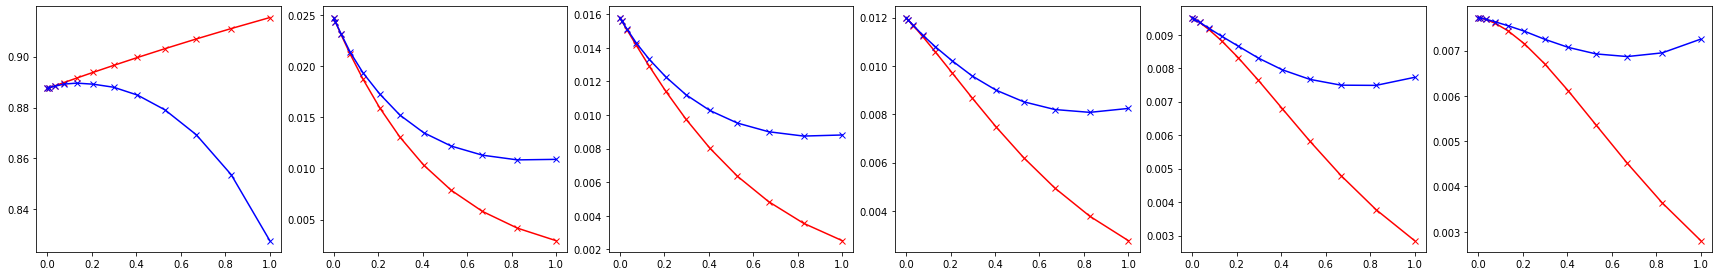

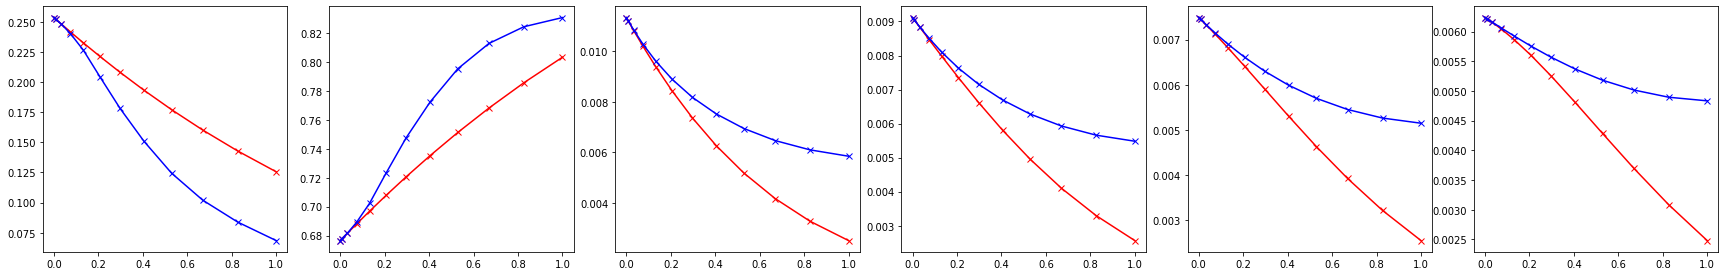

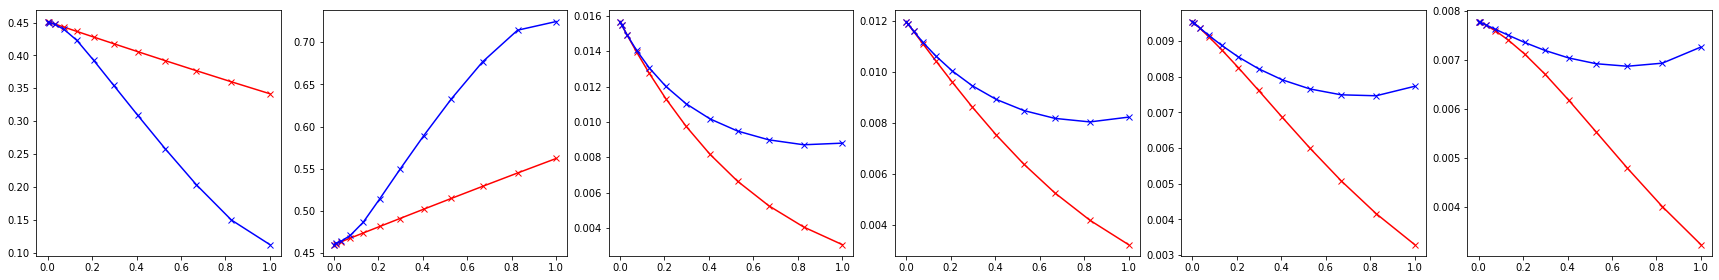

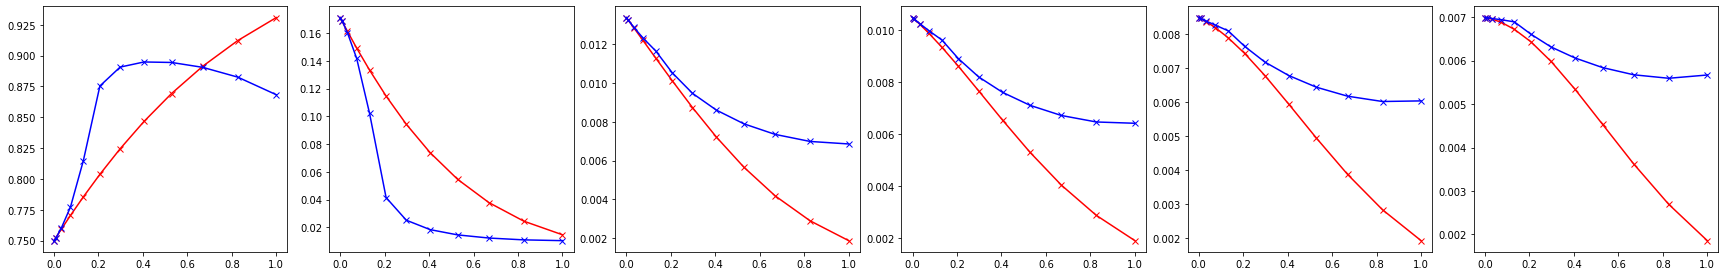

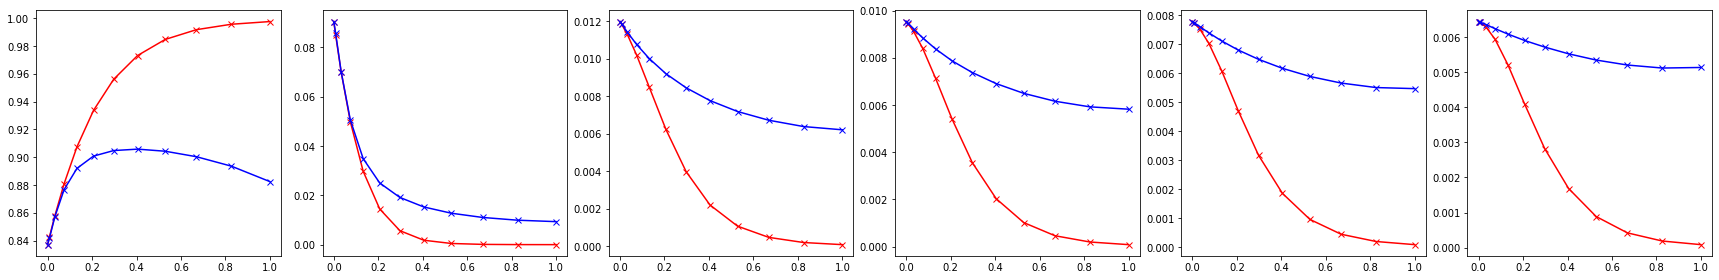

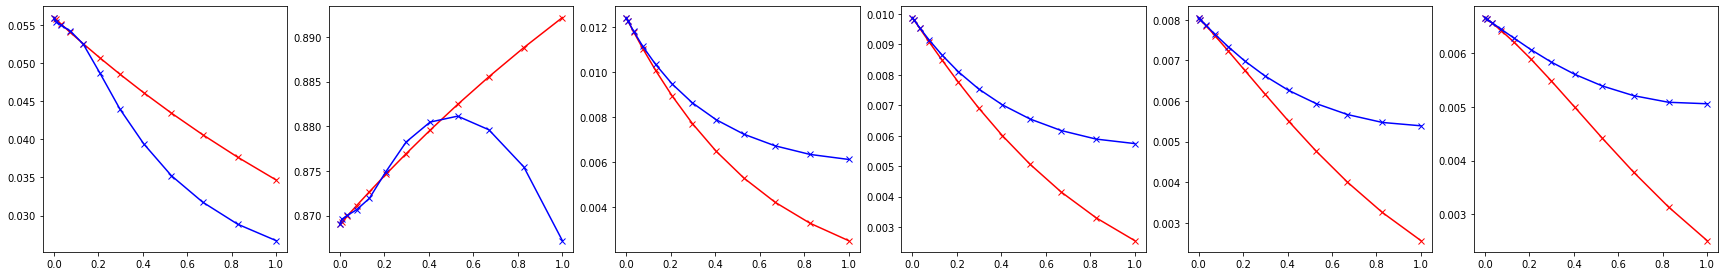

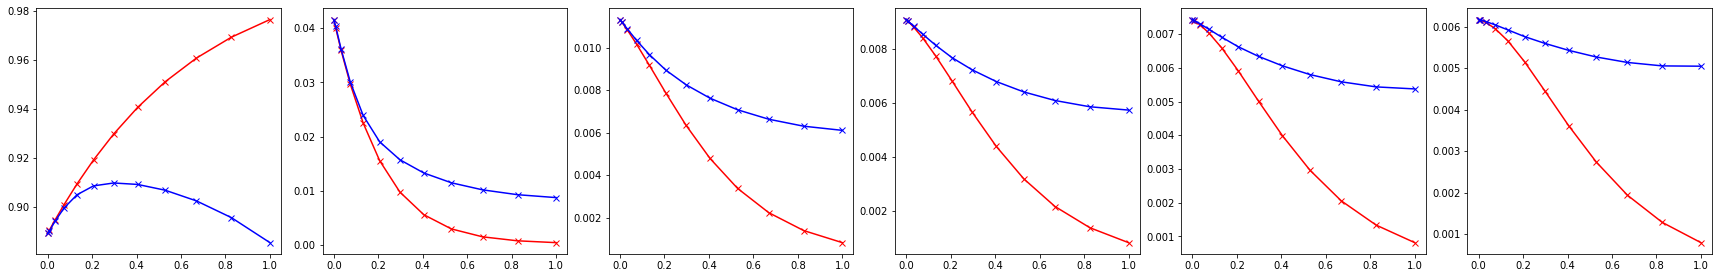

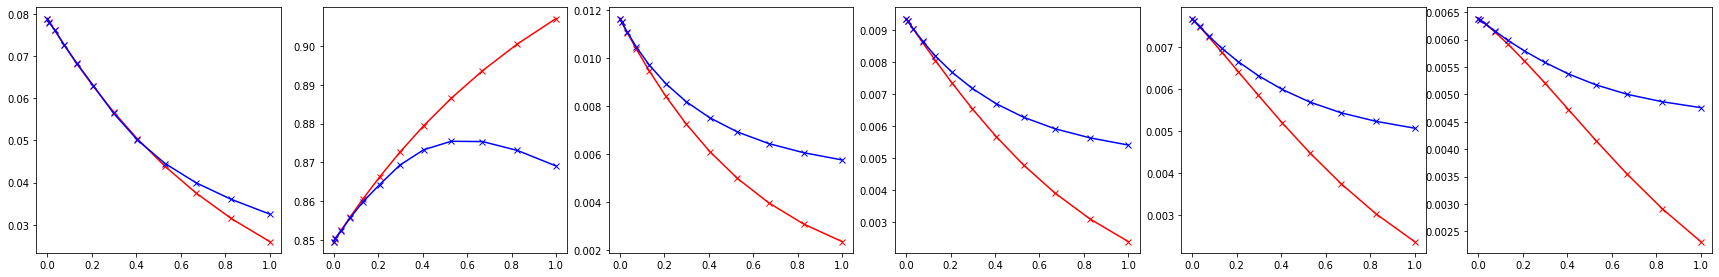

In [77]:
k_sub = 6

for n in range(g_obs.shape[0]): 

    fig, ax = plt.subplots(1, k_sub, figsize = (24, 4))
    fig.tight_layout()

    for k in range(k_sub): 
        ax[k].plot(epsilon_vec, lr_array[:, n, k], '-x', color = 'red')
        ax[k].plot(epsilon_vec, refit_array[:, n, k], '-x', color = 'blue')

In [78]:
refit_array[0, 0, :] - refit_array[-1, 0, :]

DeviceArray([ 0.02838038,  0.01100945,  0.00494267,  0.00312917,
              0.0018735 ,  0.00096302,  0.00028599, -0.00022541,
             -0.00061425, -0.00091024, -0.00113421, -0.00130097,
             -0.00142246, -0.00150769, -0.00156363, -0.00159606,
             -0.00160918, -0.00160715, -0.00159283, -0.0355001 ],            dtype=float64)

In [85]:
refit_array[0, :, -2]

DeviceArray([0.00077677, 0.00077702, 0.00084651, 0.00085066, 0.00083258,
             0.00082759, 0.00075781, 0.00098674, 0.00078151, 0.00072014,
             0.00087076, 0.00086486, 0.00076866, 0.00072165, 0.00081624,
             0.00082395, 0.00077622, 0.0009401 , 0.00079585, 0.00095349,
             0.00087273, 0.00081415, 0.00084258, 0.0007836 , 0.00081244],            dtype=float64)

In [84]:
refit_array[0, :, -1]

DeviceArray([0.00477671, 0.00477502, 0.00522073, 0.00524682, 0.00512243,
             0.00509077, 0.00465366, 0.00612989, 0.0048058 , 0.00441176,
             0.00537129, 0.00533416, 0.00472487, 0.00441945, 0.00501741,
             0.00506946, 0.00477275, 0.00583808, 0.00488621, 0.00591191,
             0.005388  , 0.00501153, 0.00518689, 0.00481809, 0.00499236],            dtype=float64)

In [80]:
refit_array[-1, 0, :]

DeviceArray([0.88410848, 0.00788874, 0.00624817, 0.0058545 , 0.0054915 ,
             0.0051555 , 0.00484351, 0.00455317, 0.00428261, 0.00403027,
             0.00379463, 0.00357405, 0.00336743, 0.00317393, 0.00299241,
             0.00282189, 0.00266165, 0.00251117, 0.0023696 , 0.04027681],            dtype=float64)

In [81]:
lr_array[-1, 0, :]

DeviceArray([0.9297763 , 0.00228   , 0.00243164, 0.00245   , 0.00241265,
             0.00235009, 0.0022849 , 0.00220251, 0.00211065, 0.00202493,
             0.00194413, 0.00186066, 0.00177667, 0.00170151, 0.0016382 ,
             0.00157866, 0.00151522, 0.00144904, 0.00139683, 0.03481543],            dtype=float64)